# 4 特徴量と予測値の関係を知る〜Partial Dependence〜

In [1]:
import sys
import warnings
from dataclasses import dataclass
from typing import Any  # 型ヒント用
from __future__ import annotations  # 型ヒント用

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib  # matplotlibの日本語表示対応

# 自作モジュール
sys.path.append("..")
from mli.visualize import get_visualization_setting

np.random.seed(42)
pd.options.display.float_format = "{:.2f}".format
sns.set(**get_visualization_setting())
warnings.simplefilter("ignore")  # warningsを非表示に

In [2]:
from sklearn.model_selection import train_test_split


def generate_simulation_data1():
    """シミュレーション1のデータを生成"""

    N = 1000  # インスタンス数
    beta = np.array([1])  # 回帰係数

    X = np.random.uniform(0, 1, [N, 1])  # 一様分布から特徴量を生成
    epsilon = np.random.normal(0, 0.1, N)  # 正規分布からノイズを生成
    y = X @ beta + epsilon  # 線形和で目的変数を作成

    return train_test_split(X, y, test_size=0.2, random_state=42)


# シミュレーションデータの生成
X_train, X_test, y_train, y_test = generate_simulation_data1()

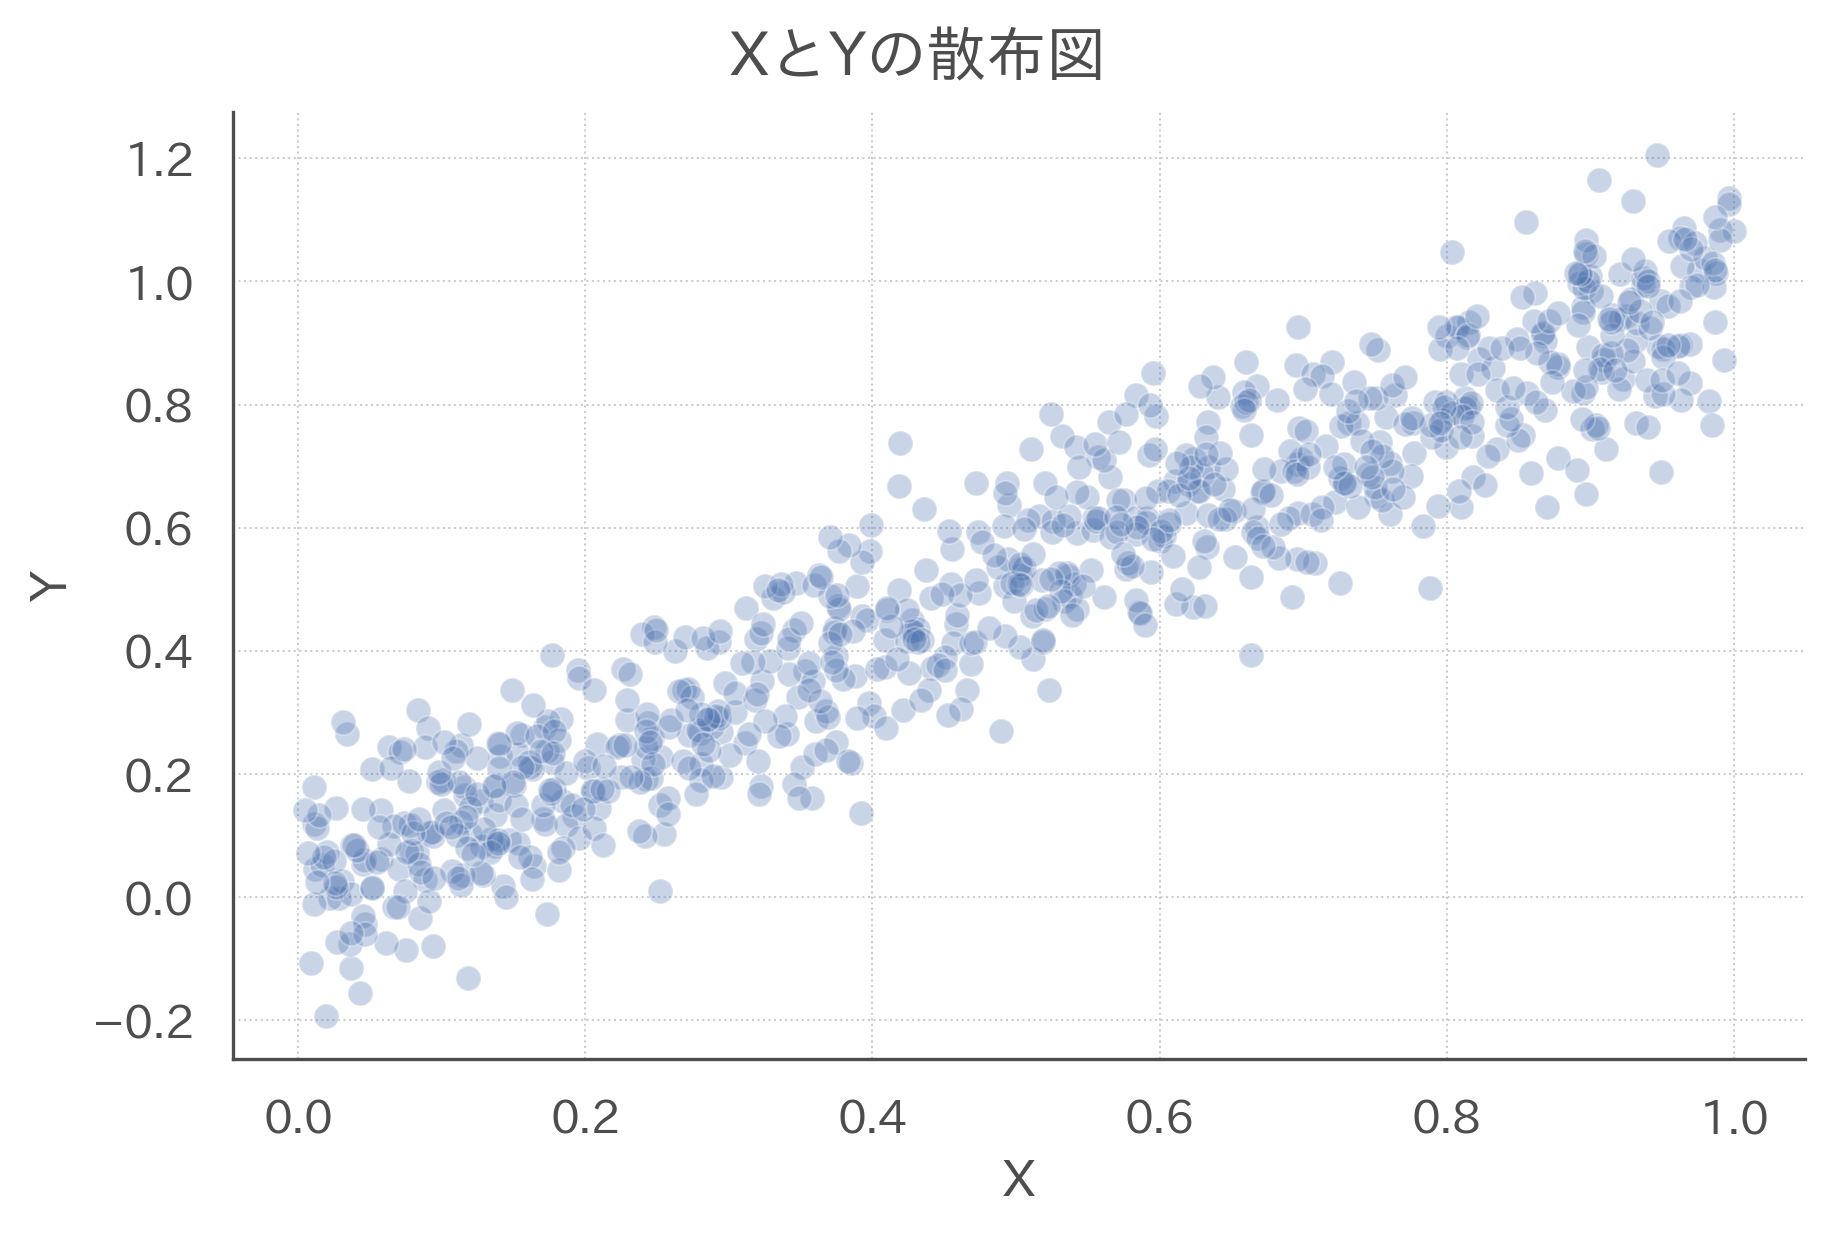

In [3]:
def plot_scatter(x, y, xlabel="X", ylabel="Y", title=None):
    """散布図を作成"""
    
    fig, ax = plt.subplots()
    sns.scatterplot(x, y, ci=None, alpha=0.3, ax=ax)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    fig.suptitle(title)
    fig.show()


#　特徴量Xと目的変数Yの散布図を作成 
plot_scatter(X_train[:, 0], y_train, title="XとYの散布図")

In [4]:
from sklearn.linear_model import LinearRegression
# 2.3節で作成した精度評価関数
from mli.metrics import regression_metrics


# 線形回帰モデルの学習
lm = LinearRegression().fit(X_train, y_train)

# 予測精度を確認
regression_metrics(lm, X_test, y_test)

,RMSE,R2
0,0.09,0.91


In [5]:
# 2.3 節で作成した回帰係数を取り出す関数
from mli.utility import get_coef


# 切片と特徴量Xの回帰係数を確認
df_coef = get_coef(lm, ['X'])
df_coef.T

,intercept,X
coef,0.02,0.98


In [6]:
def generate_simulation_data2():
    """シミュレーション2のデータを生成"""

    N = 1000  # インスタンス数

    # 一様分布から特徴量を生成
    X = np.random.uniform(-np.pi * 2, np.pi * 2, [N, 2])
    epsilon = np.random.normal(0, 0.1, N)  # 正規分布からノイズを生成

    # 特徴量X0はsin関数で変換する
    y = 10 * np.sin(X[:, 0]) + X[:, 1] + epsilon

    return train_test_split(X, y, test_size=0.2, random_state=42)


# シミュレーションデータの生成
X_train, X_test, y_train, y_test = generate_simulation_data2()

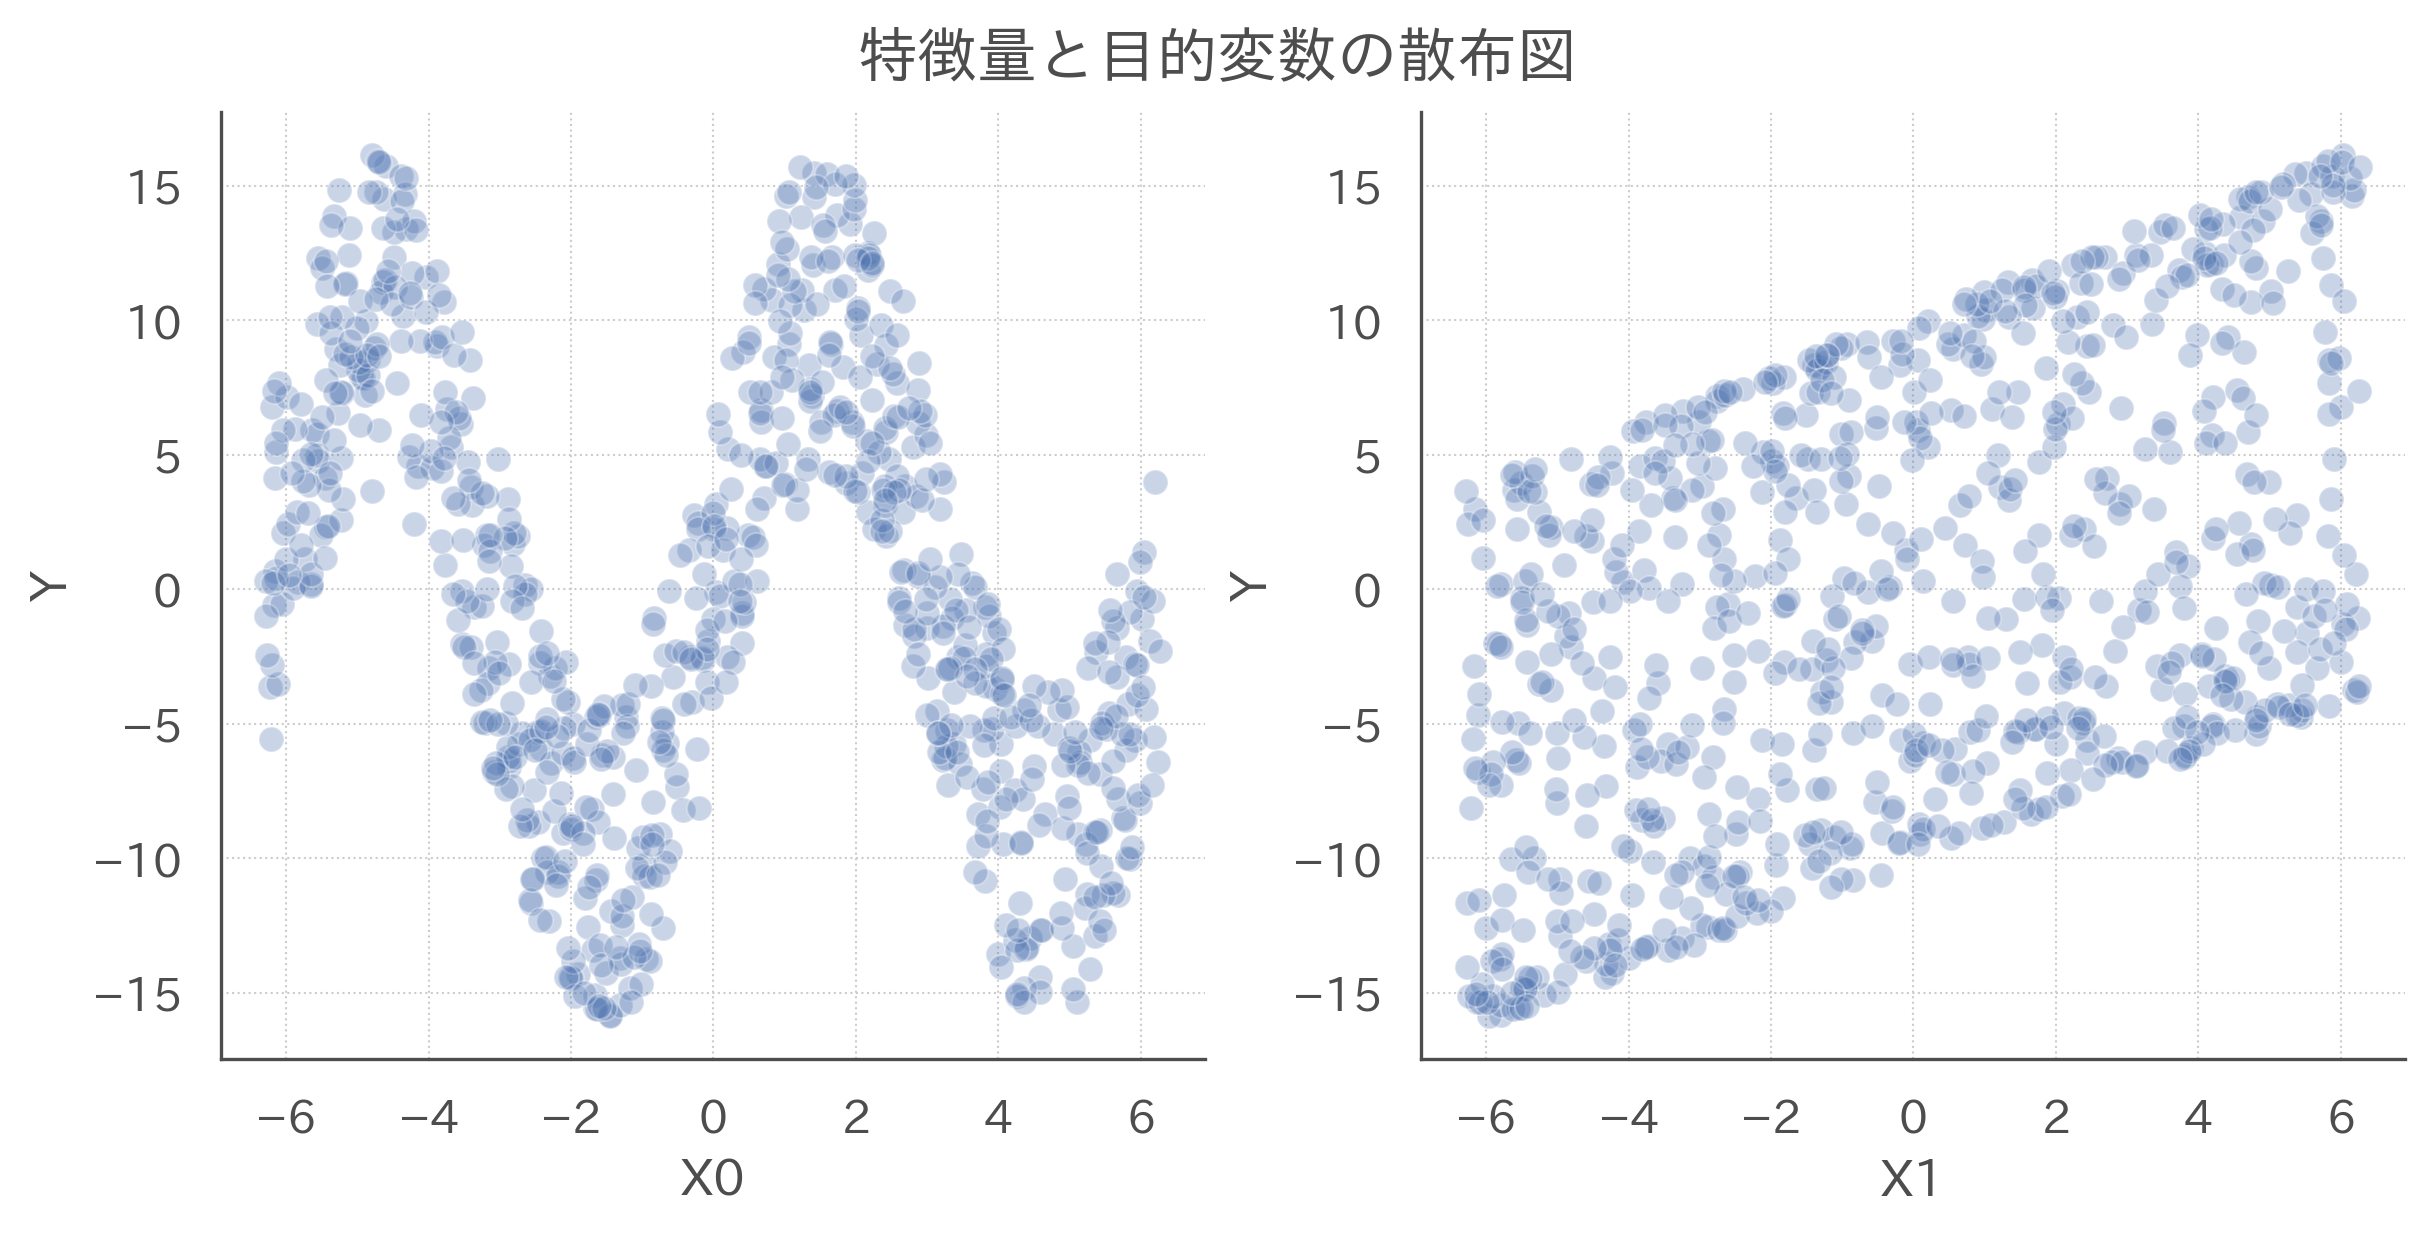

In [7]:
def plot_scatters(X, y, var_names, title=None):
    """目的変数と特徴量の散布図を作成"""
    
    # 特徴量の数だけ散布図を作成
    J = X.shape[1]
    fig, axes = plt.subplots(nrows=1, ncols=J, figsize=(4 * J, 4))

    for j, ax in enumerate(axes):
        sns.scatterplot(X[:, j], y, ci=None, alpha=0.3, ax=ax)
        ax.set(
            xlabel=var_names[j], 
            ylabel="Y", 
            xlim=(X.min() * 1.1, X.max() * 1.1)
        )
    fig.suptitle(title)
    
    fig.show()


# 特徴量ごとに目的変数との散布図を作成
plot_scatters(
    X_train, y_train, ["X0", "X1"], title="特徴量と目的変数の散布図"
)

In [8]:
# モデルの学習
lm = LinearRegression().fit(X_train, y_train)

# 予測精度の確認
regression_metrics(lm, X_test, y_test)

,RMSE,R2
0,6.67,0.23


In [9]:
# 切片と特徴量X0, X1の回帰係数を確認
df_coef = get_coef(lm, ['X0', 'X1'])
df_coef.T

,intercept,X0,X1
coef,-0.07,-0.67,1.04


In [10]:
from sklearn.ensemble import RandomForestRegressor


# Random Forestによる予測モデルの構築
rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X_train, y_train)

# 予測精度の確認
regression_metrics(rf, X_test, y_test)

,RMSE,R2
0,0.63,0.99


In [11]:
# インスタンス0を取り出す
i = 0
Xi = X_test[[i]]

# 特徴量を出力
Xi

array([[-4.51981541,  2.15082824]])

In [12]:
# インスタンス0に対する予測値
print(f"(X0, X1)=(-4.52, 2.15)のときの予測値：{rf.predict(Xi)[0]:.2f}")

(X0, X1)=(-4.52, 2.15)のときの予測値：11.34


In [13]:
def counterfactual_prediction(
    estimator, X, idx_to_replace, value_to_replace
):
    """ある特徴量の値を置き換えたときの予測値を求める

    Args:
        estimator: 学習済みモデル
        X: 特徴量
        idx_to_replace: 値を置き換える特徴量のインデックス
        value_to_replace: 置き換える値
    """
    
    # 特徴量の値を置き換える際に、元の特徴量が上書きされないよう用にコピーしておく
    X_replaced = X.copy()

    # 特徴量の値を置き換えて予測
    X_replaced[:, idx_to_replace] = value_to_replace
    y_pred = estimator.predict(X_replaced)

    return y_pred


# X0の値を-4に置き換えた場合の予測値
cp = counterfactual_prediction(rf, Xi, 0, -4)[0]
print(f"(X0, X1)=(-4, 2.15)のときの予測値：{cp:.2f}")

(X0, X1)=(-4, 2.15)のときの予測値：9.94


In [14]:
# X0の値を-3置き換えた場合の予測値を出力
cp = counterfactual_prediction(rf, Xi, 0, -3)[0]
print(f"(X0, X1)=(-3, 2.15)のときの予測値：{cp:.2f}")

(X0, X1)=(-3, 2.15)のときの予測値：1.79


In [15]:
# X0の取りうる範囲を50個に分割
X0_range = np.linspace(-np.pi * 2, np.pi * 2, num=50)

# 取りうる範囲でX0の値を動かして予測値を生成
cps = np.concatenate(
    [counterfactual_prediction(rf, Xi, 0, x) for x in X0_range]
)
cps

array([ 3.72747496,  5.35648566,  6.46803636,  9.81052742, 10.34656833,
       11.10597881, 11.25133659, 11.18031594, 10.8610084 ,  9.92394846,
        6.89326327,  5.0085197 ,  2.37358993,  1.47155612, -1.15791917,
       -4.55232128, -6.13612767, -7.03176711, -7.22416675, -7.11925117,
       -6.83872309, -5.46391118, -3.7255065 , -1.06292811,  1.06397094,
        3.94616855,  6.46706046,  8.25499836, 10.26496369, 11.23096435,
       11.37427655, 11.47102149, 11.19247837, 10.17956387,  8.64157563,
        6.74996686,  4.83458094,  0.96744961, -1.2455745 , -3.27593454,
       -4.91988178, -6.17947148, -6.8627974 , -6.96319808, -6.89121805,
       -6.35729808, -4.97703504, -2.93614326, -1.01799067,  0.23539247])

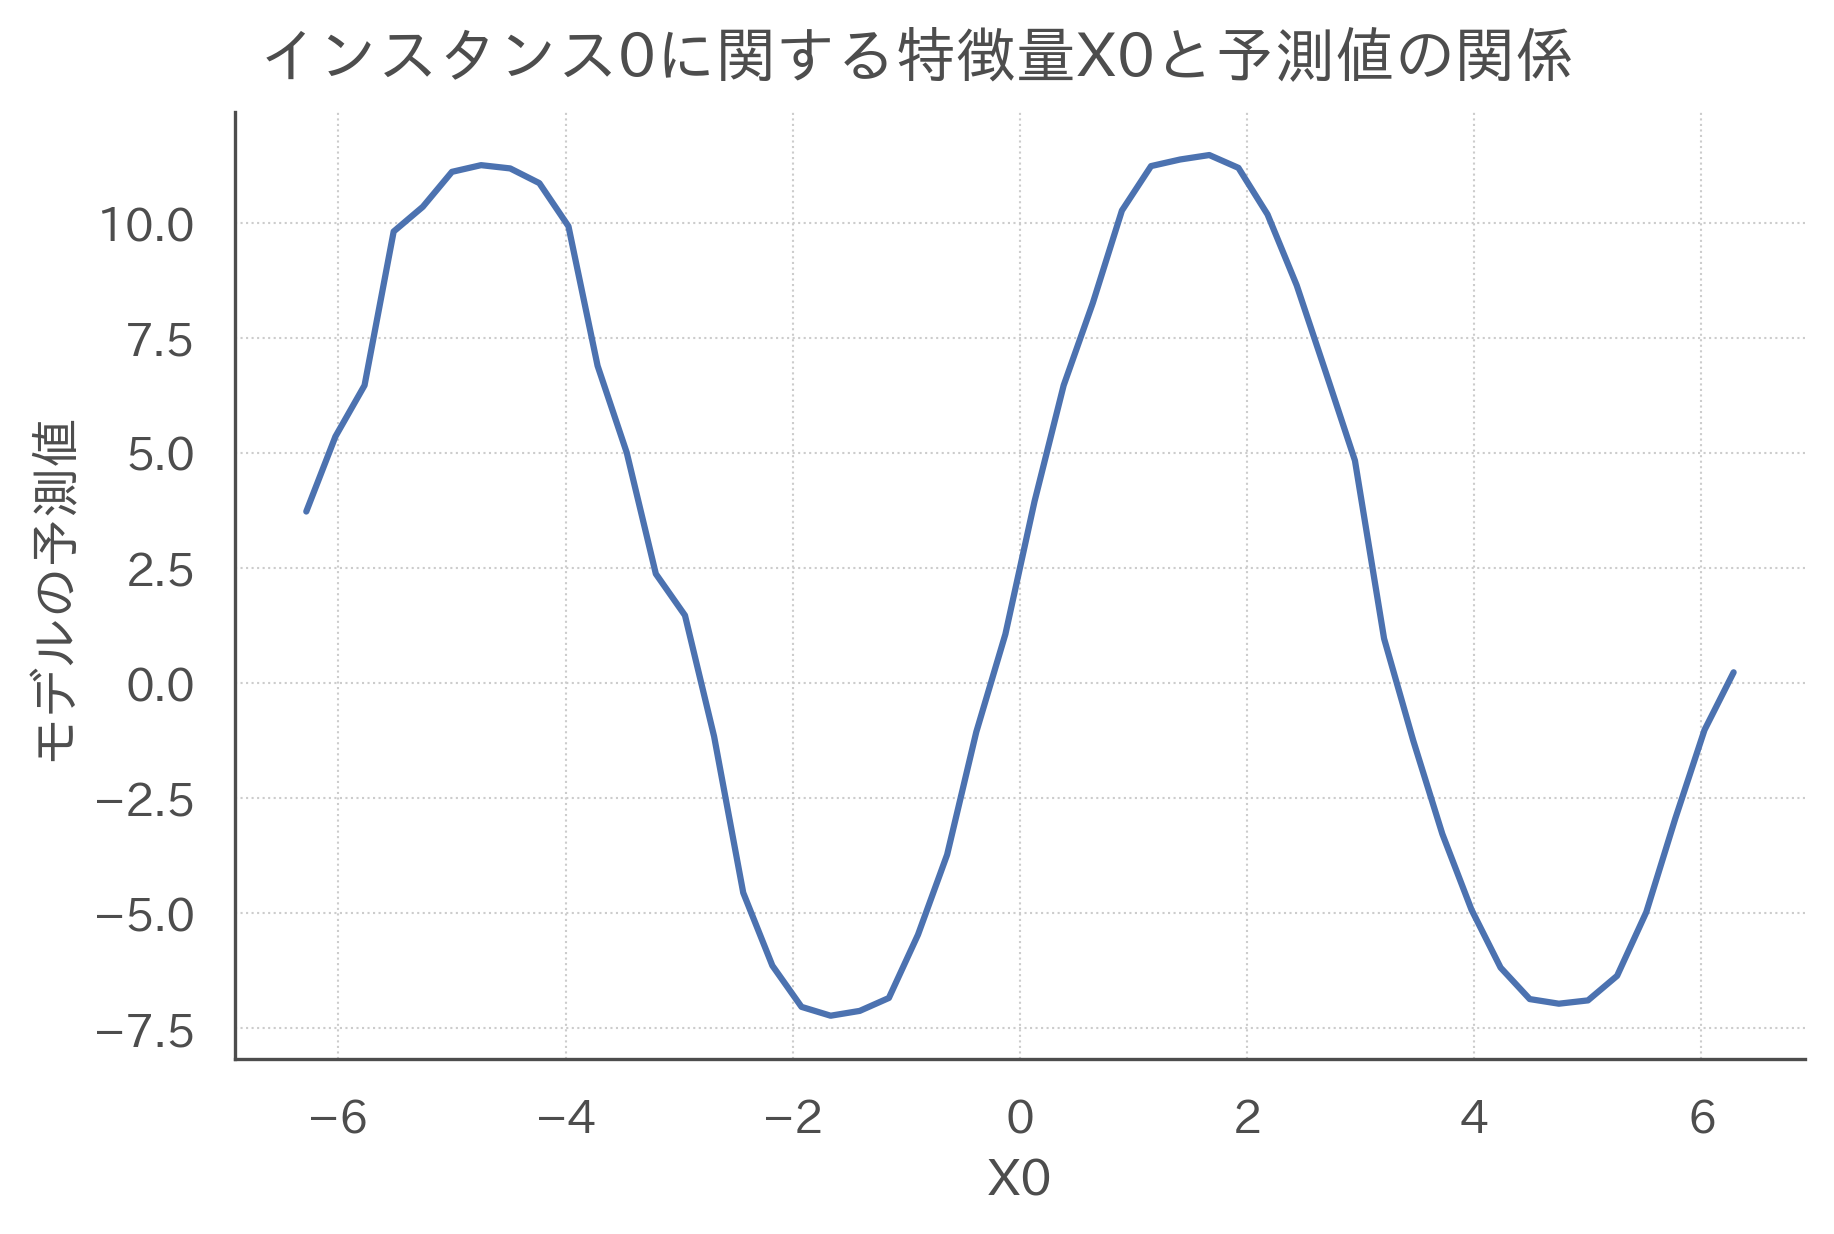

In [16]:
def plot_line(x, y, xlabel="X", ylabel="Y", title=None):
    """特徴量の値を変化させた場合の予測値の推移を可視化"""
    
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    fig.suptitle(title)
    
    fig.show()

    
# 可視化
plot_line(
    X0_range, 
    cps, 
    "X0", 
    "モデルの予測値", f"インスタンス{i}に関する特徴量X0と予測値の関係"
)

In [17]:
# インスタンス10を取り出す。
i = 10
Xi = X_test[[i]]

# 特徴量を出力
Xi

array([[ 0.91787536, -2.19646089]])

In [18]:
# インスタンス10に対する予測値
print(f"(X0, X1)=(0.92, -2.20)のときの予測値：{rf.predict(Xi)[0]:.2f}")

(X0, X1)=(0.92, -2.20)のときの予測値：5.39


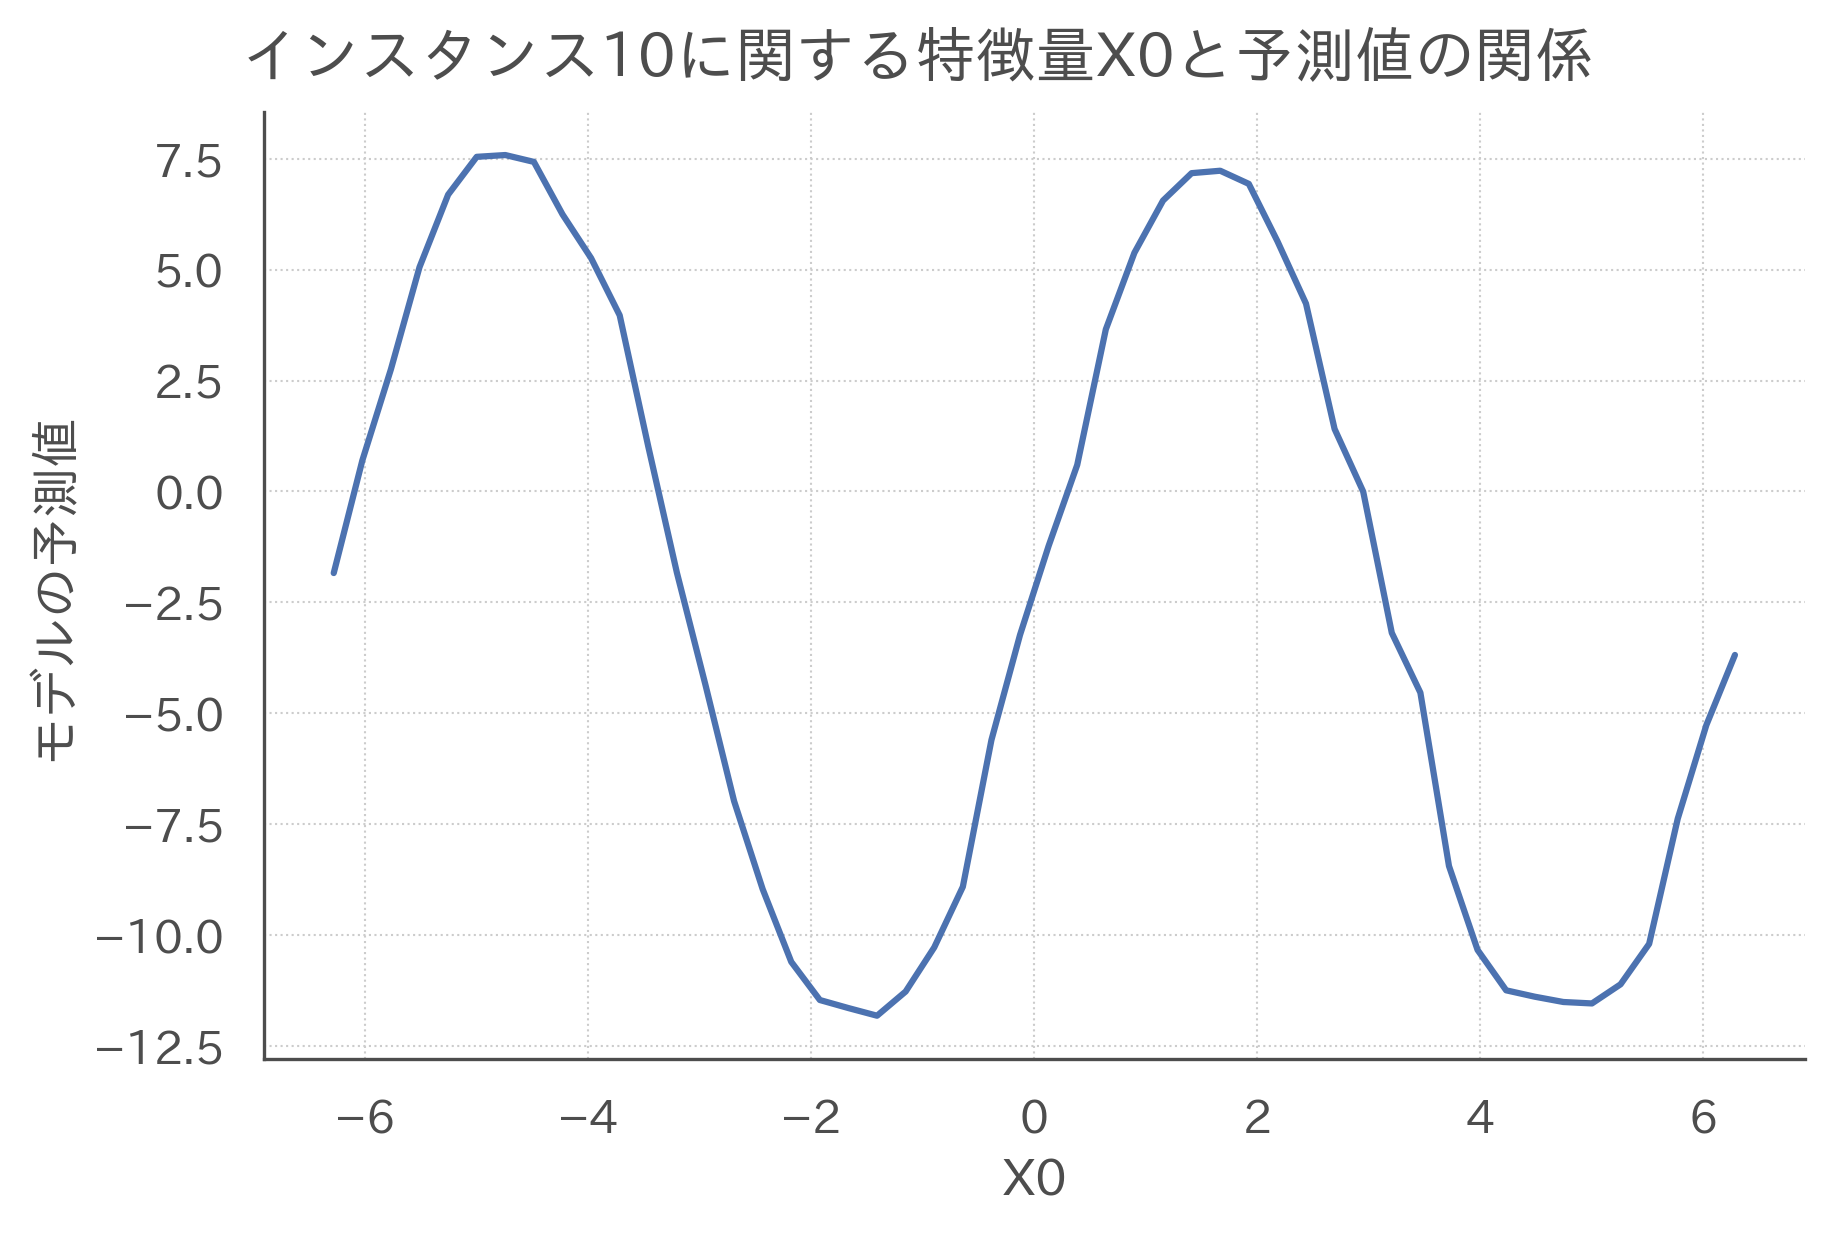

In [19]:
# インスタンス10についてもX0の値を動かして予測値を生成
cps = np.concatenate(
    [counterfactual_prediction(rf, Xi, 0, x) for x in X0_range]
)

# 可視化
plot_line(
    X0_range, 
    cps, 
    "X0",
    "モデルの予測値",
    f"インスタンス{i}に関する特徴量X0と予測値の関係"
)

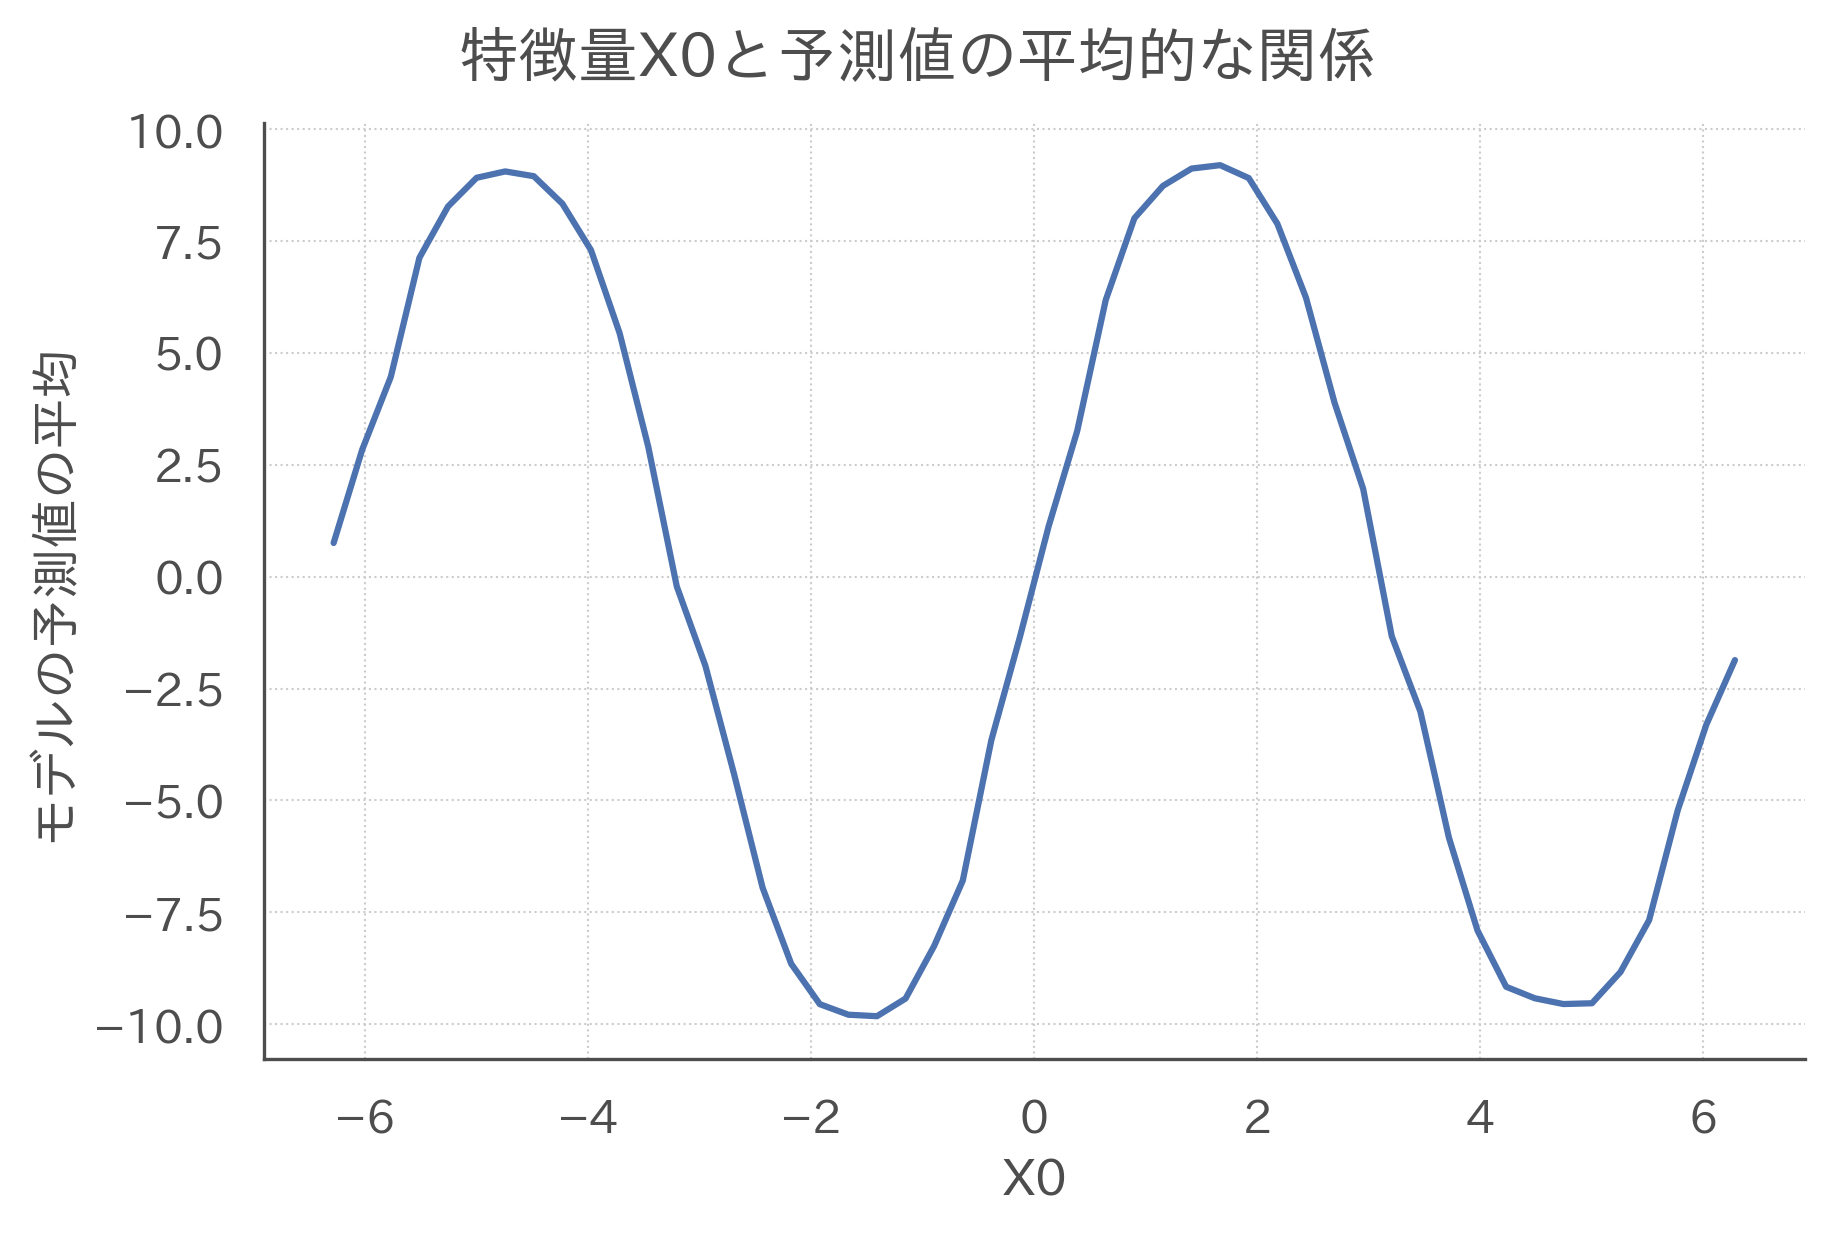

In [20]:
# すべてのインスタンスに対して予測値を出し、インスタンスごとの結果を平均する
avg_cps = np.array(
    [counterfactual_prediction(rf, X_test, 0, x).mean() for x in X0_range]
)

# 可視化
plot_line(
    X0_range,
    avg_cps,
    "X0",
    "モデルの予測値の平均",
    "特徴量X0と予測値の平均的な関係"
)

In [21]:
@dataclass
class PartialDependence:
    """Partial Dependence (PD)

    Args:
        estimator: 学習済みモデル
        X: 特徴量
        var_names: 特徴量の名前
    """
    
    estimator: Any
    X: np.ndarray
    var_names: list[str]
    
    def _counterfactual_prediction(
        self,
        idx_to_replace: int,
        value_to_replace: float
    ) -> np.ndarray:
        """ある特徴量の値を置き換えたときの予測値を求める

        Args:
            idx_to_replace: 値を置き換える特徴量のインデックス
            value_to_replace: 置き換える値
        """

        # 特徴量の値を置き換える際、元データが上書きされないようコピー
        X_replaced = self.X.copy()

        # 特徴量の値を置き換えて予測
        X_replaced[:, idx_to_replace] = value_to_replace
        y_pred = self.estimator.predict(X_replaced)

        return y_pred

    def partial_dependence(
        self,
        var_name: str,
        n_grid: int = 50
    ) -> None:
        """PDを求める

        Args:
            var_name: 
                PDを計算したい特徴量の名前
            n_grid: 
                グリッドを何分割するか
                細かすぎると値が荒れるが、粗すぎるとうまく関係を捉えられない
                デフォルトは50
        """
        
        # 可視化の際に用いるのでターゲットの変数名を保存
        self.target_var_name = var_name  
        # 変数名に対応するインデックスをもってくる
        var_index = self.var_names.index(var_name)

        # ターゲットの変数を、取りうる値の最大値から最小値まで動かせるようにする
        value_range = np.linspace(
            self.X[:, var_index].min(), 
            self.X[:, var_index].max(), 
            num=n_grid
        )

        # インスタンスごとのモデルの予測値を平均
        average_prediction = np.array([
            self._counterfactual_prediction(var_index, x).mean()
            for x in value_range
        ])

        # データフレームとしてまとめる
        self.df_partial_dependence = pd.DataFrame(
            data={var_name: value_range, "avg_pred": average_prediction}
        )

    def plot(self, ylim: list[float] | None = None) -> None:
        """PDを可視化

        Args:
            ylim: 
                Y軸の範囲
                特に指定しなければavg_predictionの範囲となる
                異なる特徴量のPDを比較したいときなどに指定する
        """

        fig, ax = plt.subplots()
        ax.plot(
            self.df_partial_dependence[self.target_var_name],
            self.df_partial_dependence["avg_pred"],
        )
        ax.set(
            xlabel=self.target_var_name,
            ylabel="Average Prediction",
            ylim=ylim
        )
        fig.suptitle(f"Partial Dependence Plot ({self.target_var_name})")
        
        fig.show()

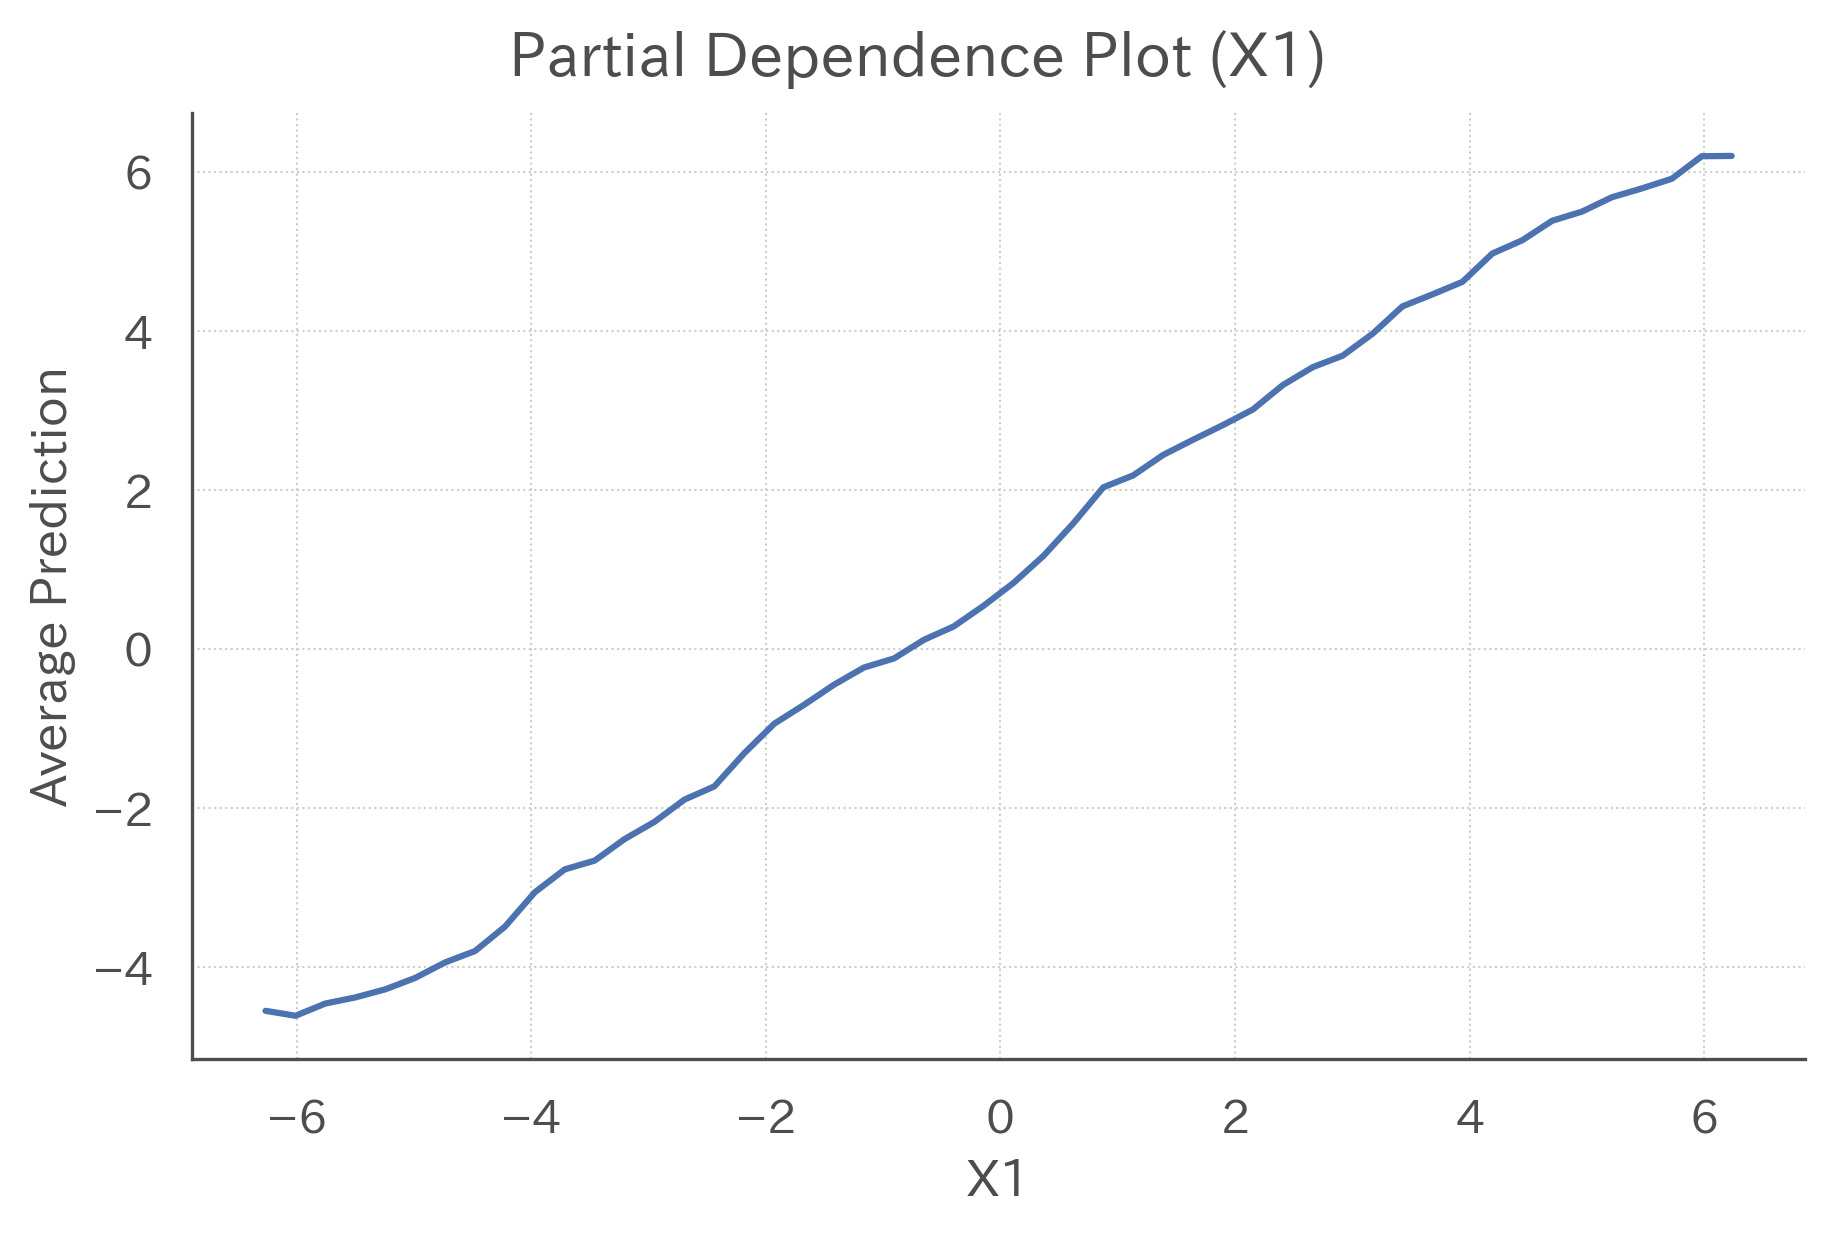

In [22]:
# PDのインスタンスを作成
# pandasとかぶるので、変数名はpdではなくpdp(partial dependence plot)とした
pdp = PartialDependence(rf, X_test, ["X0", "X1"])

# X1に対するPDを計算
pdp.partial_dependence("X1", n_grid=50)

# PDを可視化
pdp.plot()

In [23]:
def generate_simulation_data3():
    """シミュレーション3のデータを生成"""

    N = 1000  # インスタンス数
    beta = np.array([0, 1])  # 回帰係数

    # 多変量正規分布から強く相関するデータを生成
    mu = np.array([0, 0])
    Sigma = np.array([[1, 0.95], [0.95, 1]])
    X = np.random.multivariate_normal(mu, Sigma, N)
    epsilon = np.random.normal(0, 0.1, N)  # 正規分布からノイズを生成
    y = X @ beta + epsilon  # 線形和で目的変数を作成

    return train_test_split(X, y, test_size=0.2, random_state=42)


# シミュレーションデータの生成
X_train, X_test, y_train, y_test = generate_simulation_data3()

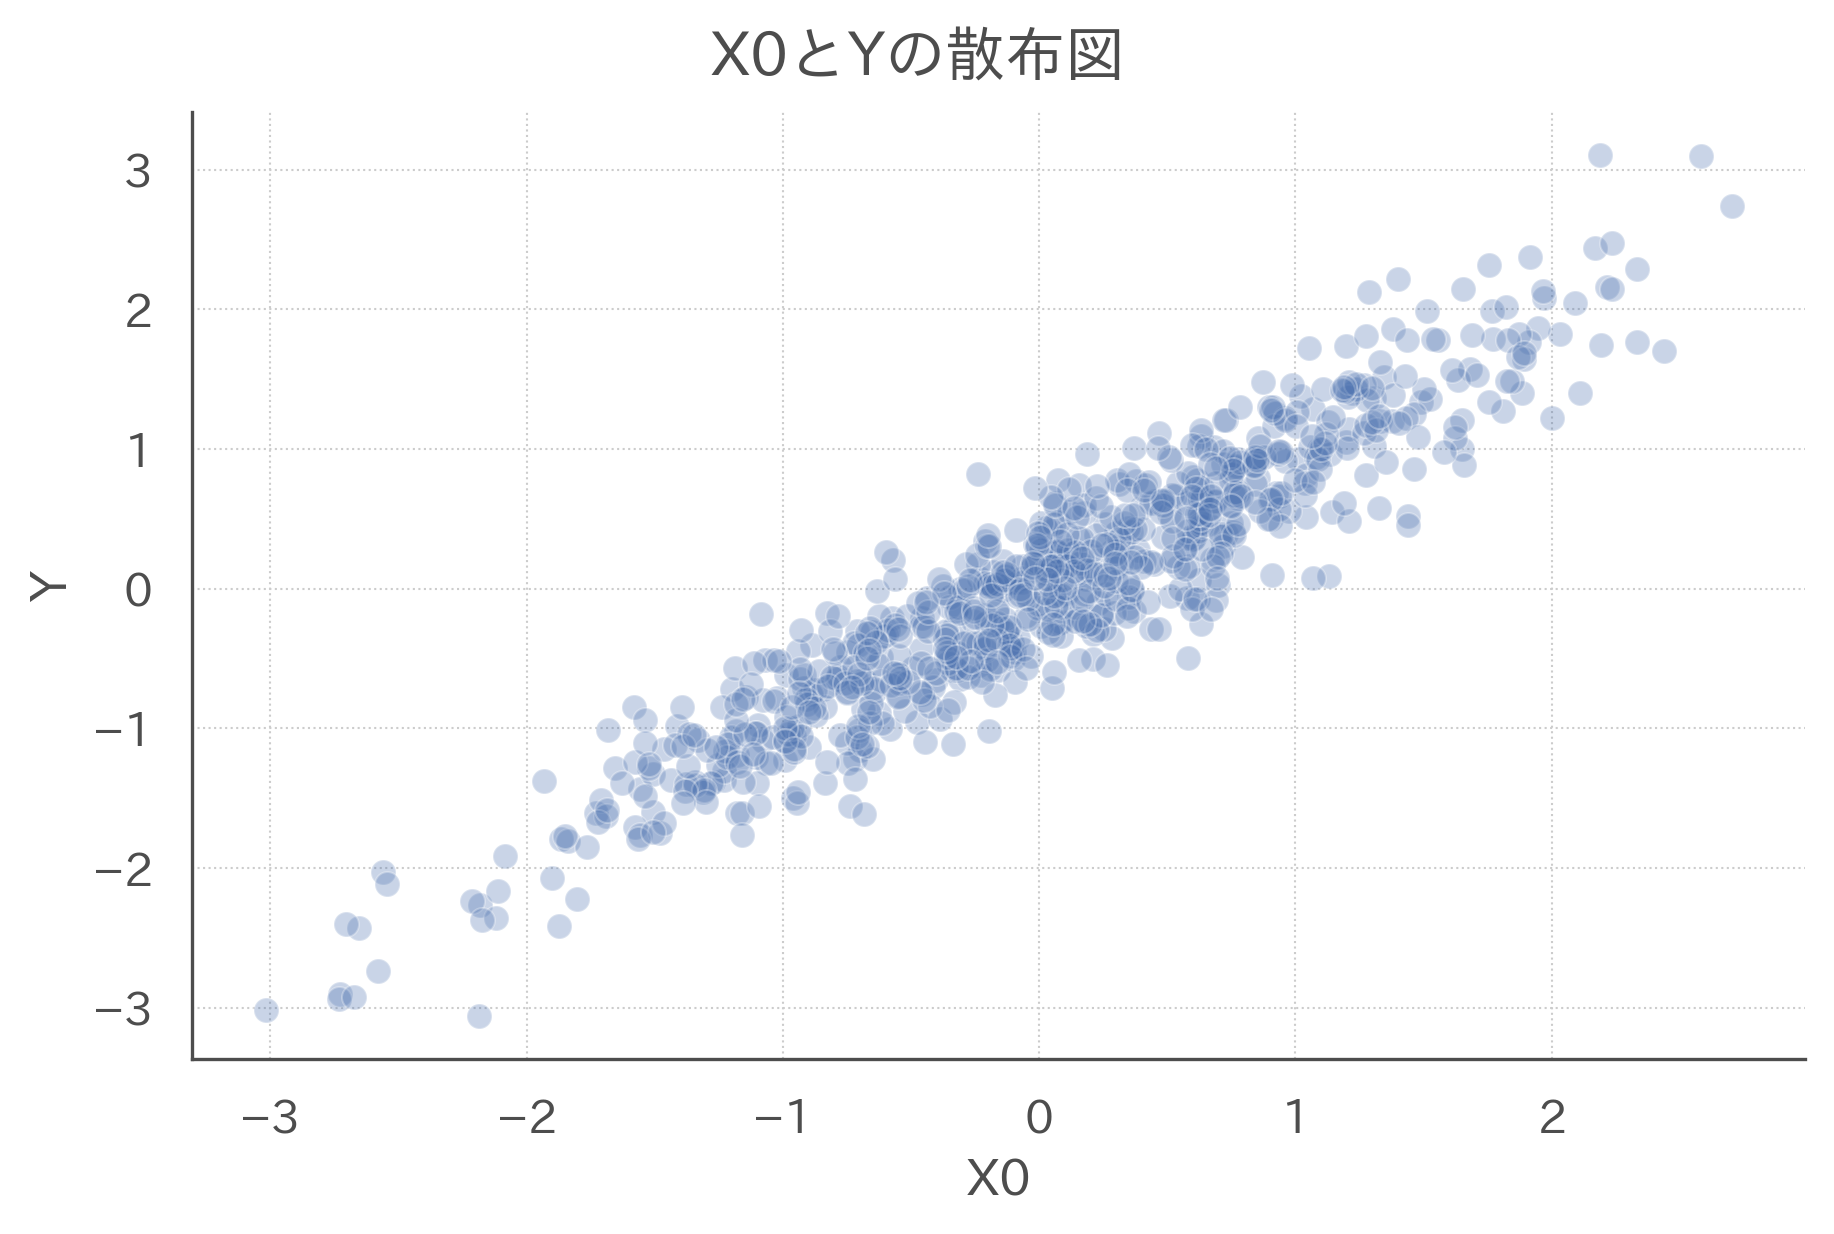

In [24]:
# 散布図を作成
plot_scatter(X_train[:, 0], y_train, xlabel="X0", title="X0とYの散布図")

In [25]:
# モデルの学習
rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X_train, y_train)

# 予測精度の確認
regression_metrics(rf, X_test, y_test)

,RMSE,R2
0,0.12,0.99


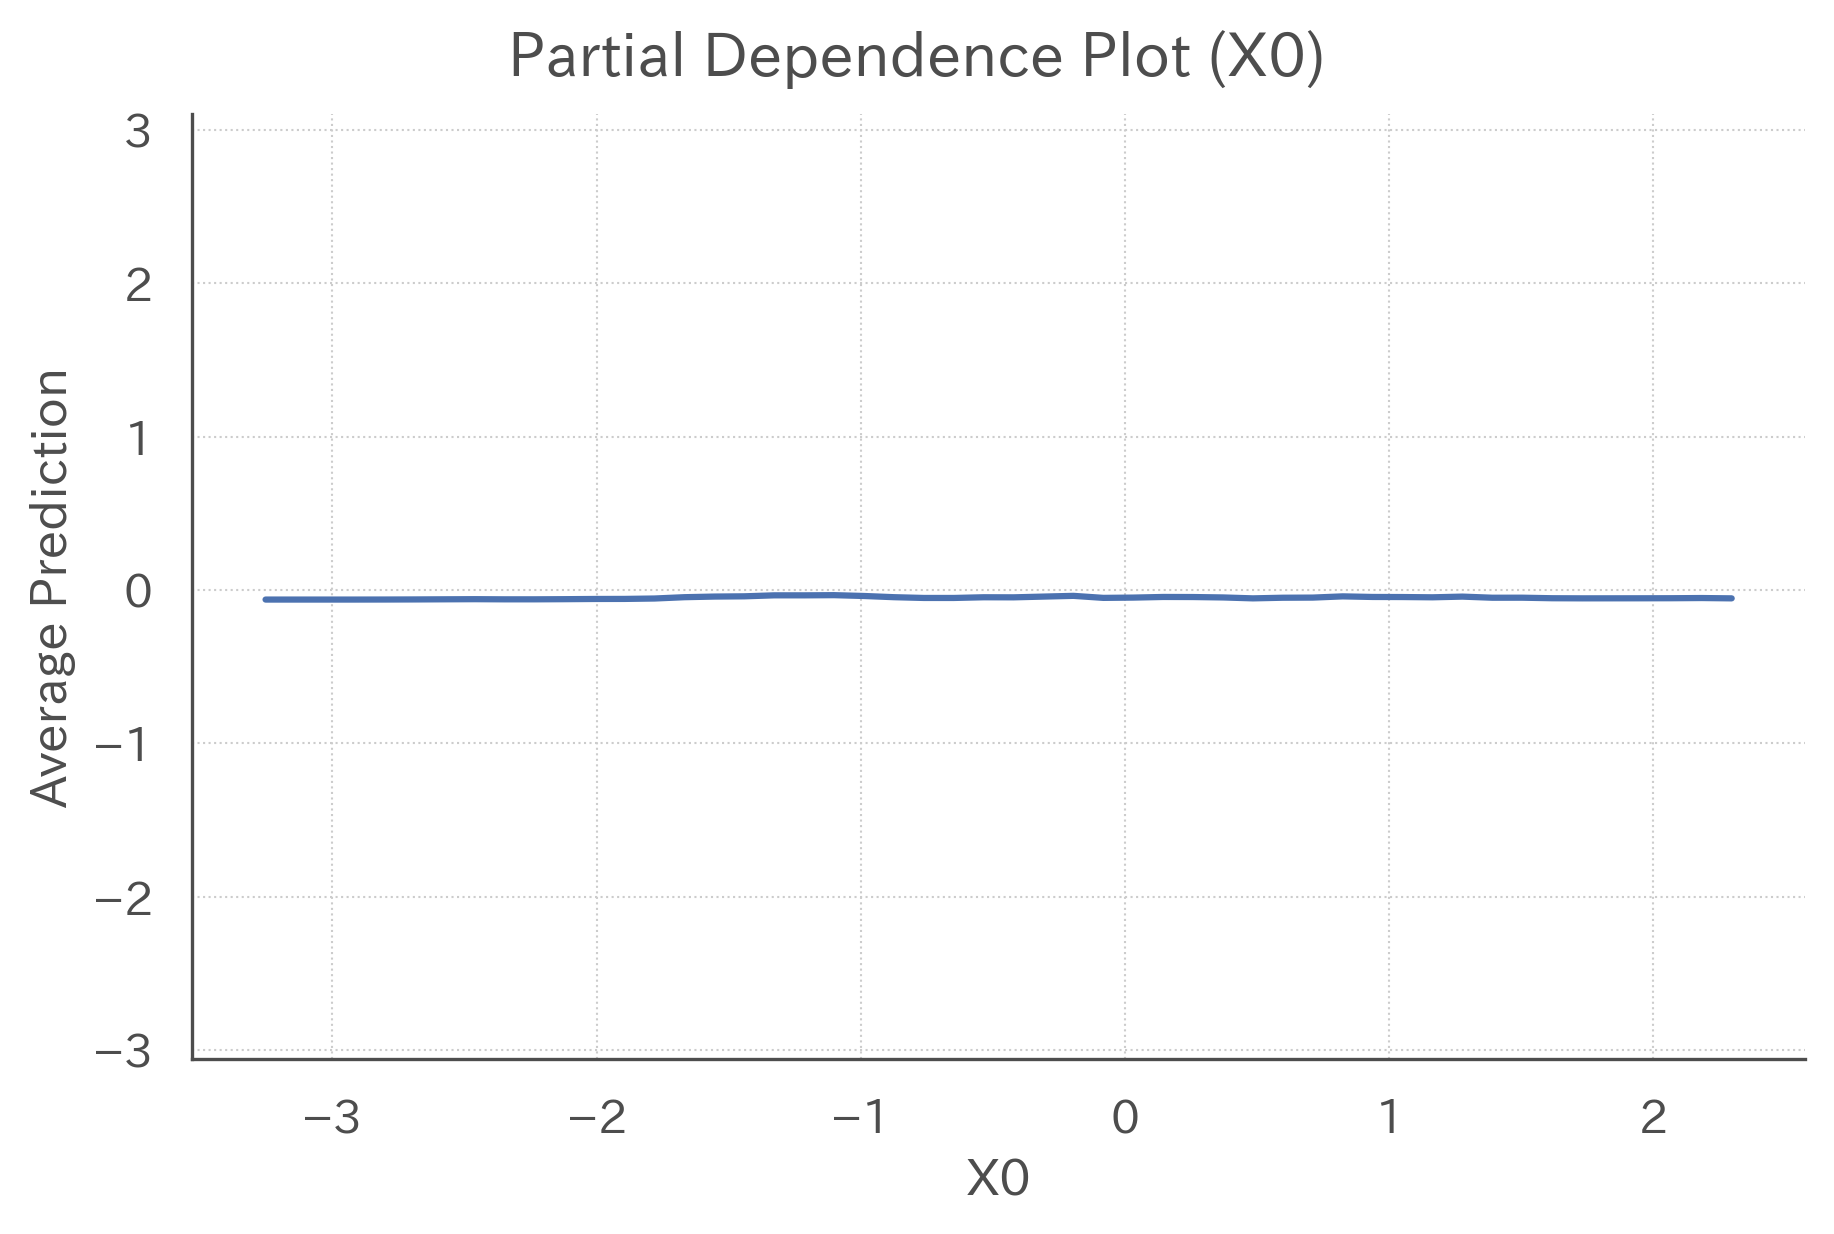

In [26]:
# PDのインスタンスを作成
pdp = PartialDependence(rf, X_test, ["X0", "X1"])

# X0に対するPDを計算
pdp.partial_dependence("X0", n_grid=50)

# PDを可視化
pdp.plot(ylim=(y_train.min(), y_train.max()))

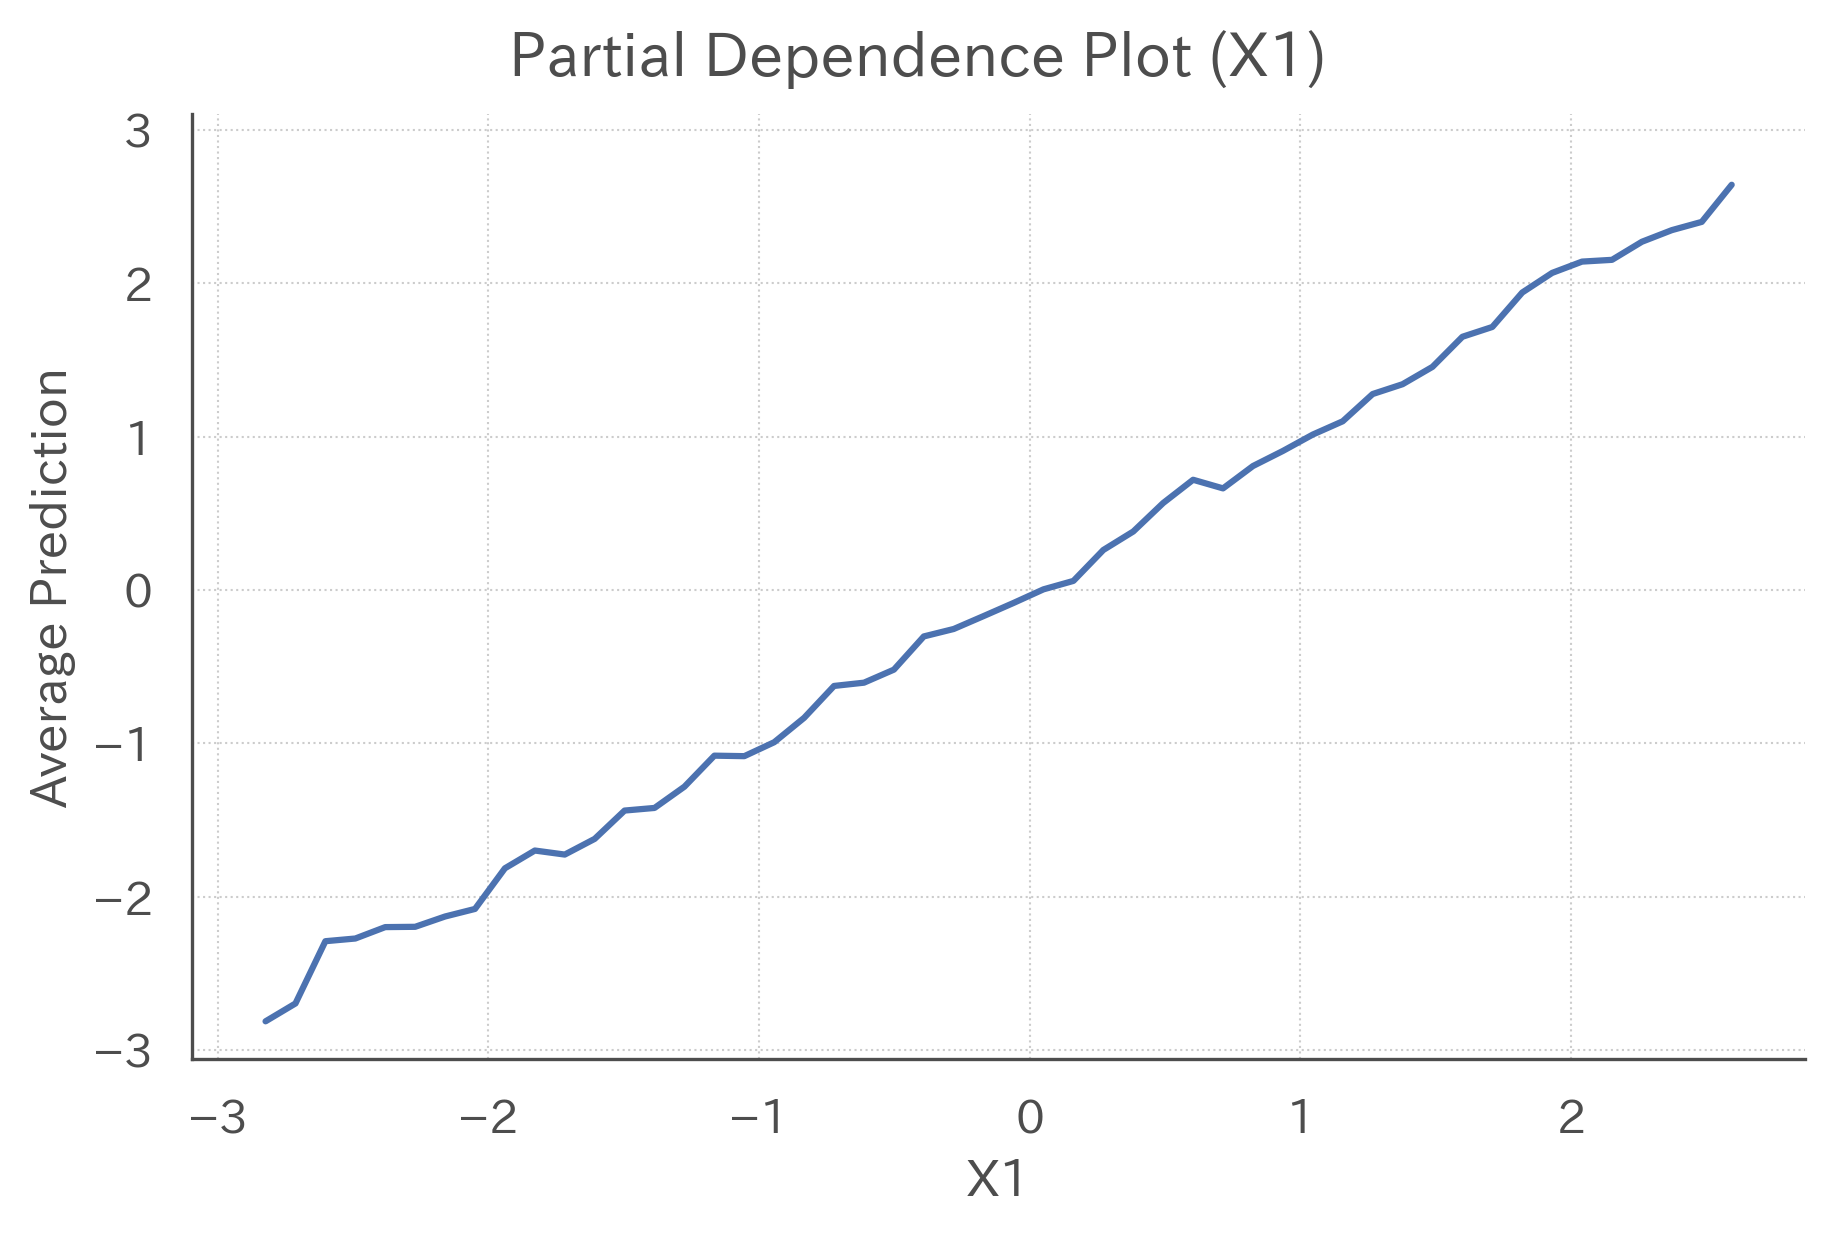

In [27]:
# X1に対するPDを計算、可視化
pdp.partial_dependence("X1", n_grid=50)
pdp.plot(ylim=(y_train.min(), y_train.max()))

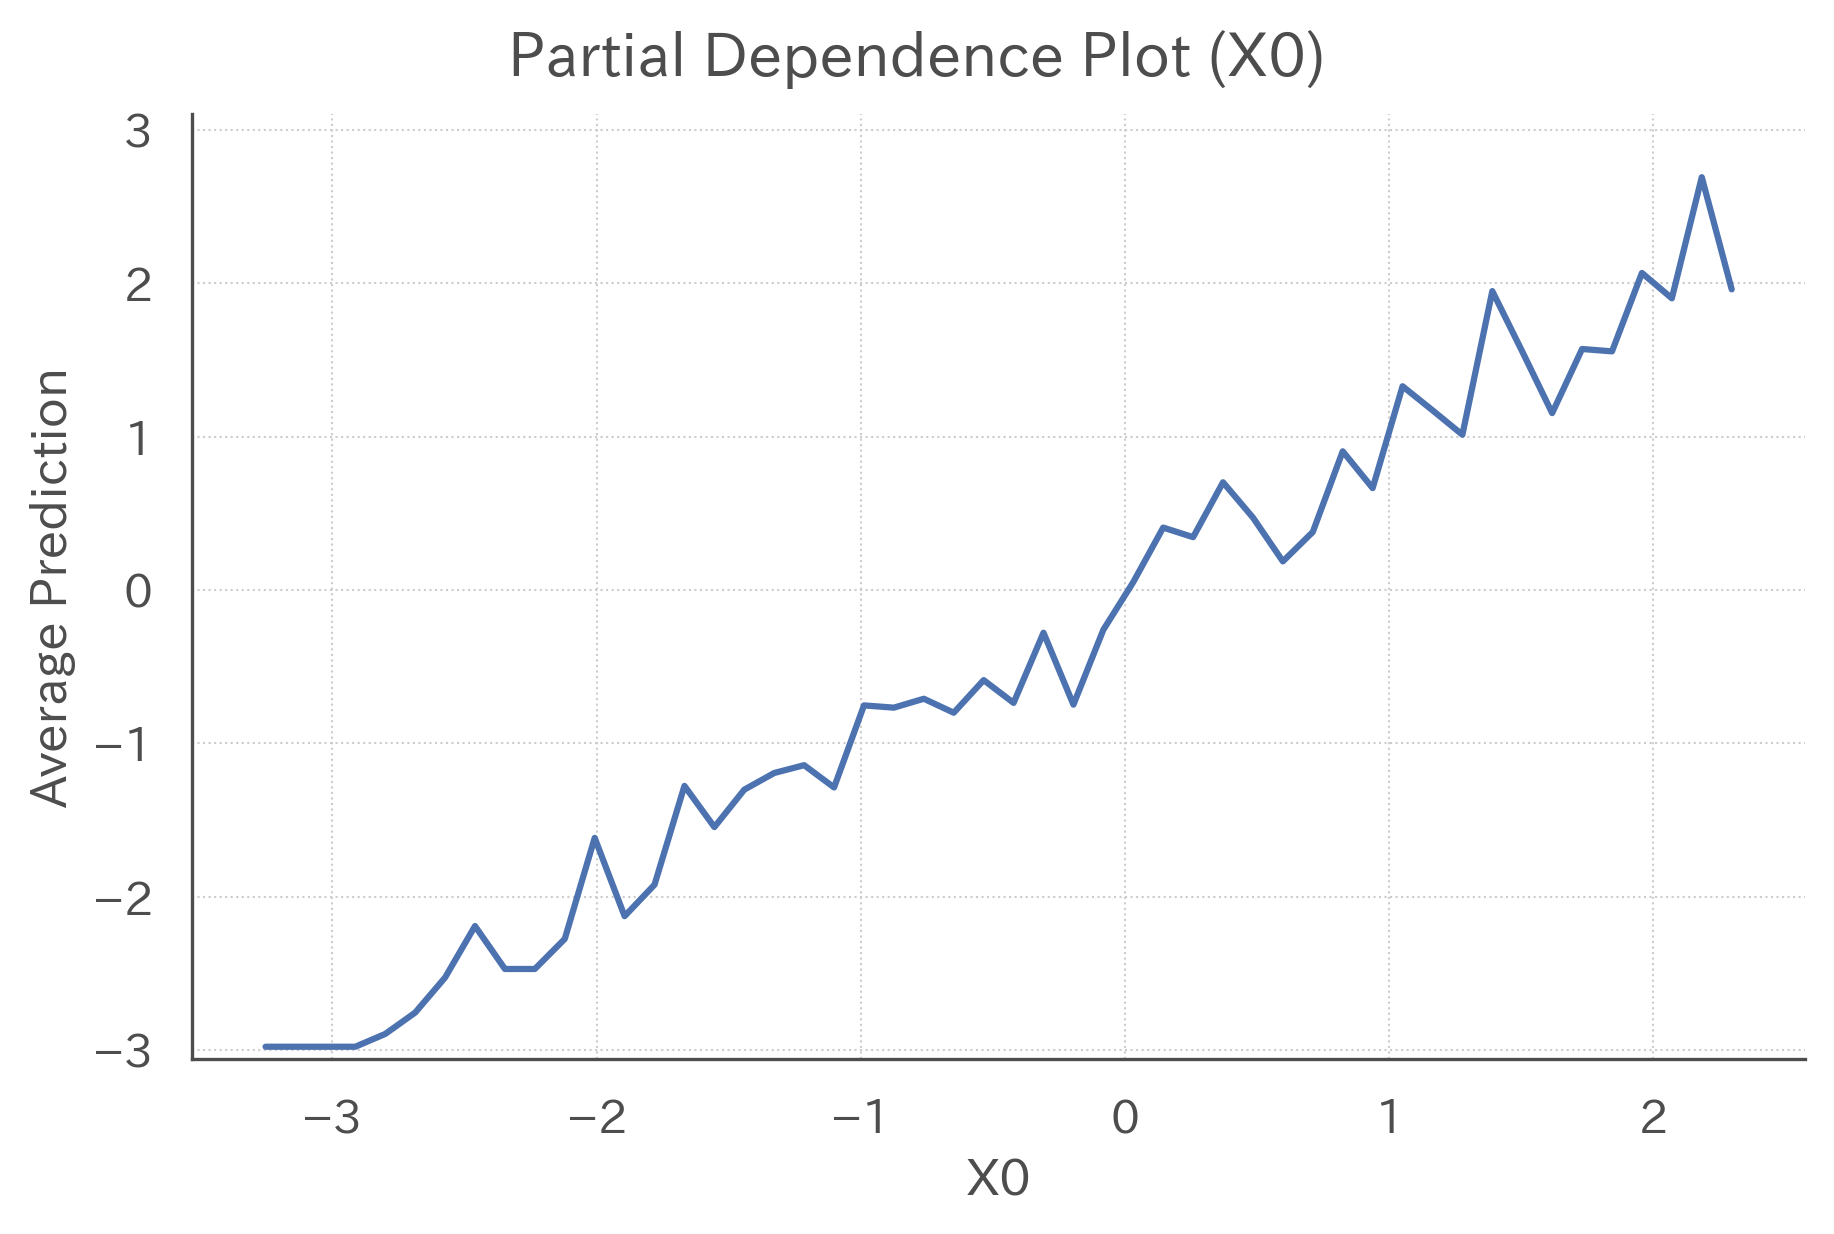

In [28]:
# モデルの学習
rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X_train[:, [0]], y_train)

# PDのインスタンスを作成
pdp = PartialDependence(rf, X_test[:, [0]], ["X0"])

# X0に対するPDを計算
pdp.partial_dependence("X0", n_grid=50)

# PDを可視化
pdp.plot(ylim=(y_train.min(), y_train.max()))

In [29]:
# 予測精度の確認
regression_metrics(rf, X_test[:, [0]], y_test)

,RMSE,R2
0,0.36,0.89


In [30]:
import joblib

# データと学習済みモデルを読み込む
X_train, X_test, y_train, y_test = joblib.load("../data/boston_housing.pkl")
rf = joblib.load("../model/boston_housing_rf.pkl")

In [31]:
from sklearn.inspection import partial_dependence


# PDを計算
pdp = partial_dependence(
    estimator=rf,  # 学習済みモデル
    X=X_test,  # PDを計算したいデータ
    features=["RM"],  # PDを計算したい特徴量
    kind="average",  # PDは"average"、ICEは"individual"、両方は"both"
)
pdp

{'average': array([[18.66547229, 18.57526133, 18.56737376, 18.54758385, 18.3557727 ,
         18.52827679, 18.53226078, 18.54175193, 18.54552367, 18.54588063,
         18.54662548, 18.55045122, 18.55085761, 18.55495458, 18.54702239,
         18.64160021, 18.64353251, 18.58288335, 18.67271398, 18.67271398,
         18.67789295, 18.95742257, 18.96943722, 19.11834056, 19.10607532,
         19.12118527, 19.12879441, 19.12732714, 19.123495  , 19.12689931,
         19.13831759, 19.15118039, 19.17665401, 19.17552648, 19.20053275,
         19.21520746, 19.23094474, 19.23320045, 19.23219859, 19.23316058,
         19.2110902 , 19.20710238, 19.20476529, 19.19190103, 19.32569873,
         19.32573341, 19.9018527 , 19.94187968, 20.01937062, 20.03393345,
         20.03379949, 20.02617008, 20.02465524, 20.02805844, 20.02988654,
         20.02895378, 20.03337274, 20.02074318, 20.05631722, 20.06278711,
         20.11396812, 20.11265297, 20.12037627, 20.16133279, 20.17429266,
         20.19522938, 20.17

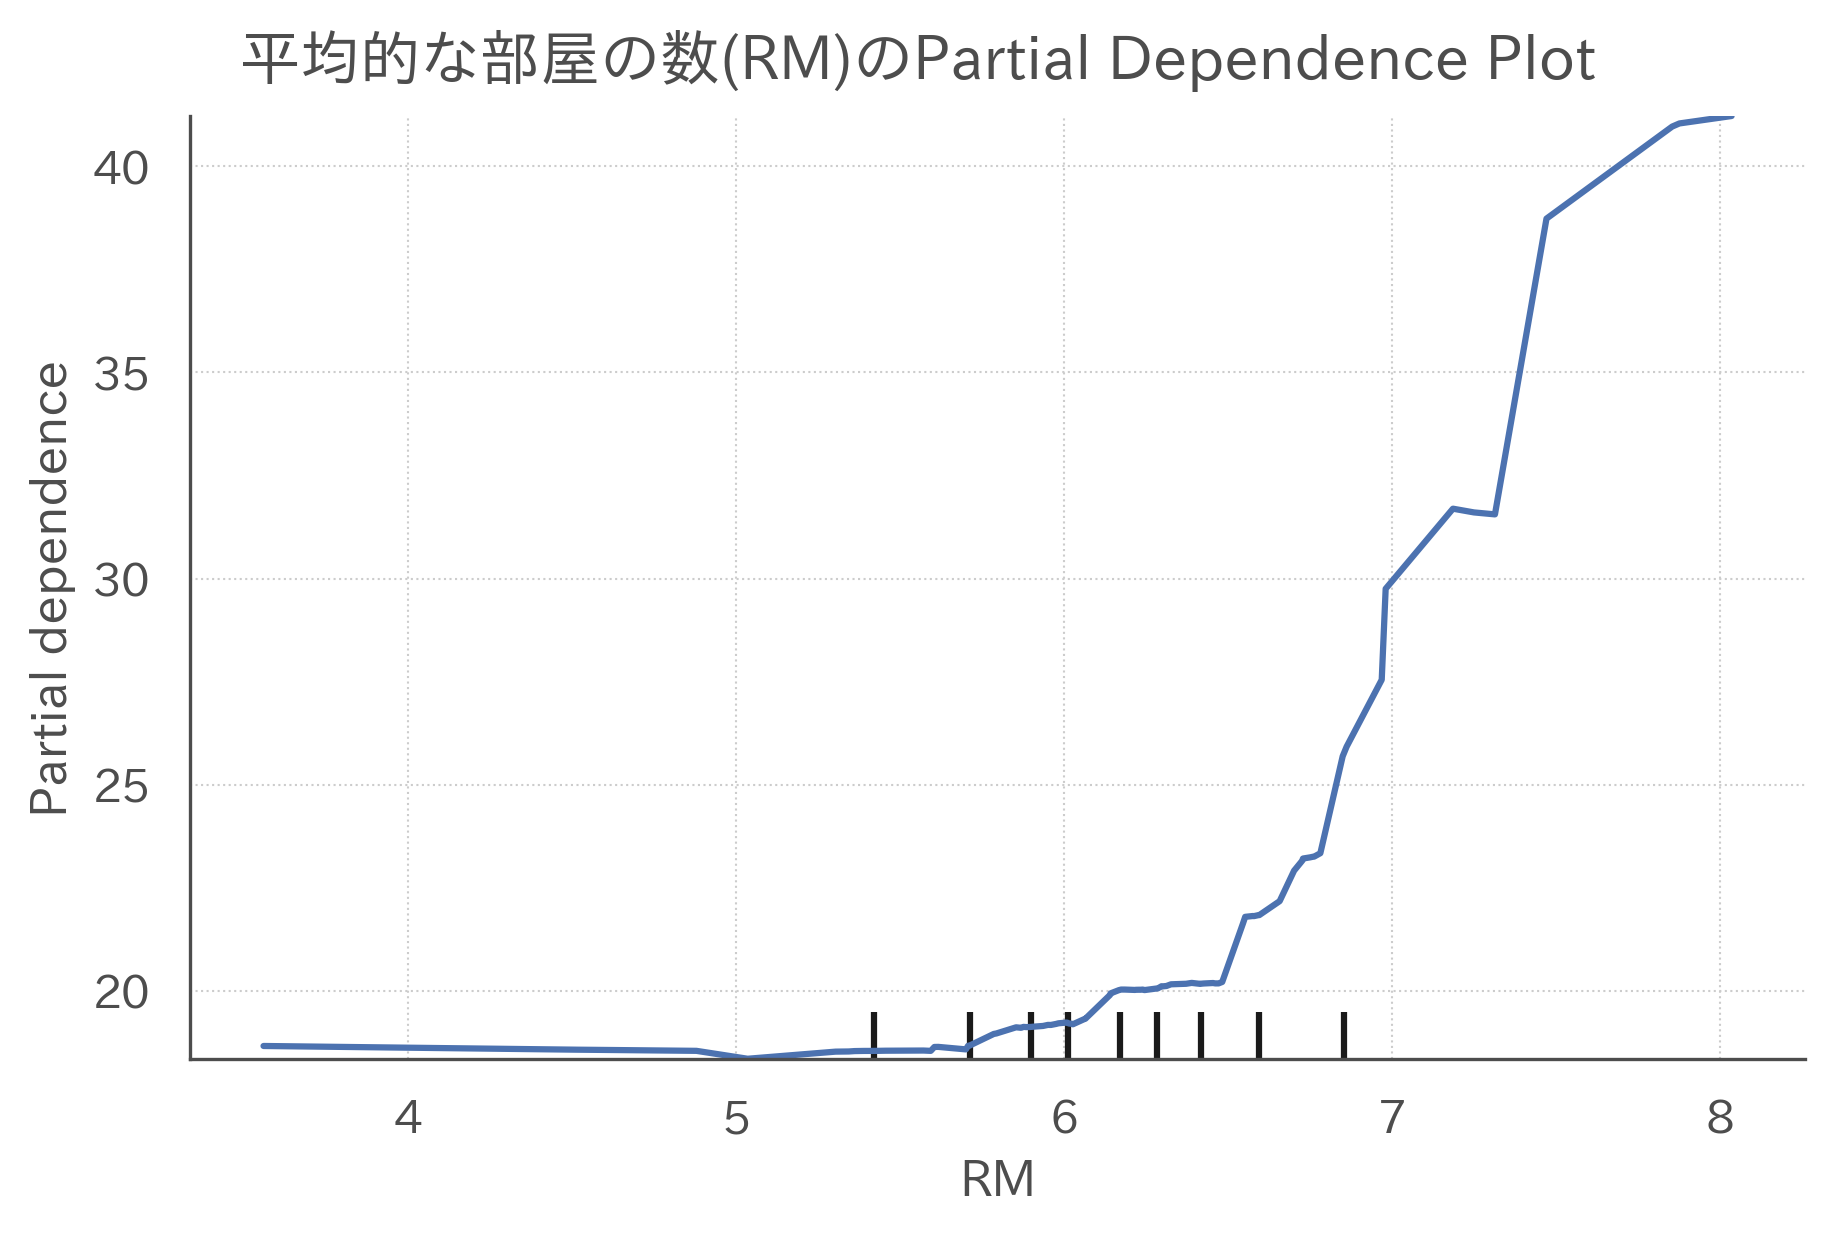

In [32]:
from sklearn.inspection import plot_partial_dependence


# 何度か使うのでplot_partial_dependence()を利用した関数を作成しておく
def plot_boston_pd(var_name, var_name_jp):
    """PDを可視化する関数"""

    fig, ax = plt.subplots()
    plot_partial_dependence(
        estimator=rf,  # 学習済みモデル
        X=X_test,  # PDを計算したいデータ
        features=[var_name],  # PDを計算したい特徴量
        kind="average",  # PDは"average"、ICEは"individual"、両方は"both"
        ax=ax,
    )
    fig.suptitle(f"{var_name_jp}({var_name})のPartial Dependence Plot")

    fig.show()


plot_boston_pd("RM", "平均的な部屋の数")

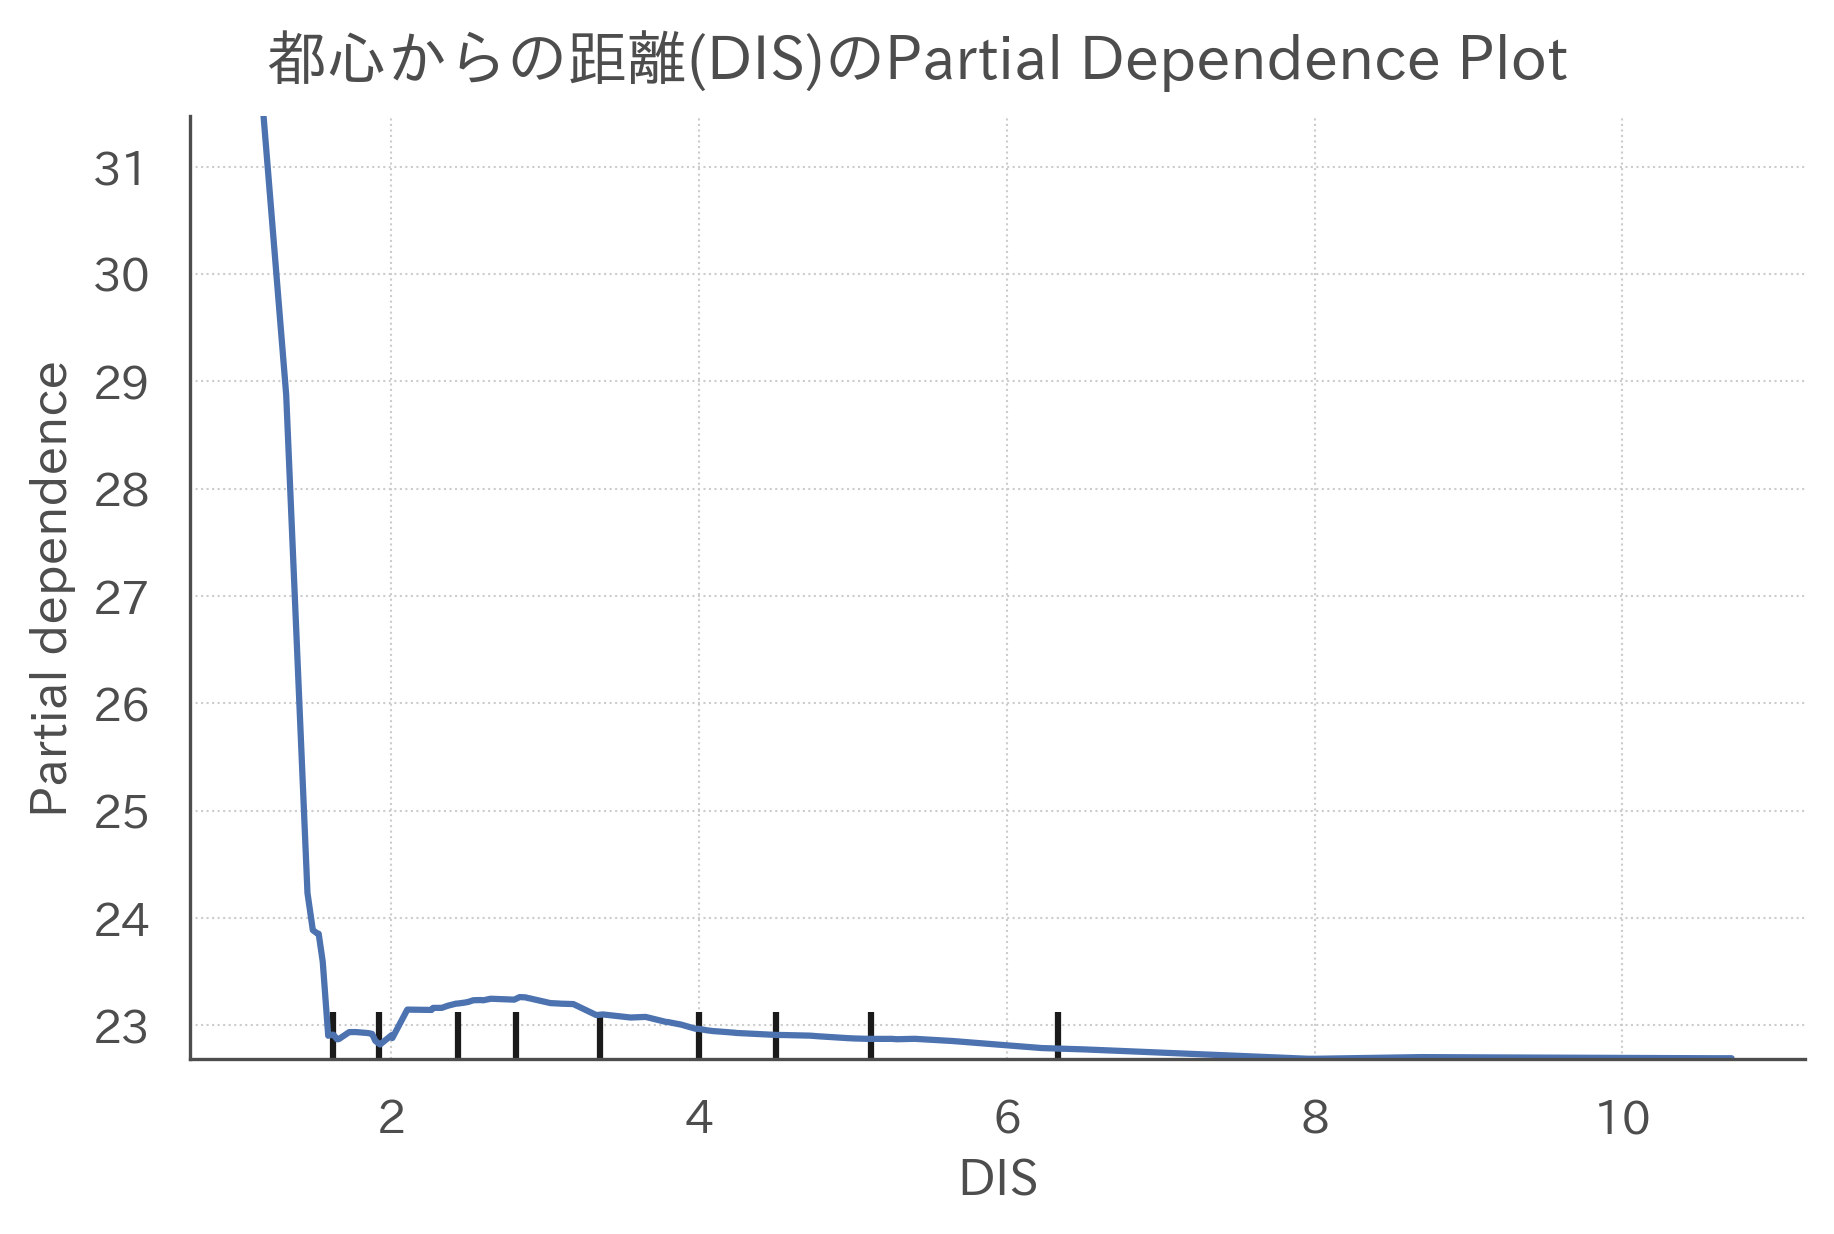

In [33]:
# DISについてもPDを可視化
plot_boston_pd("DIS", "都心からの距離")

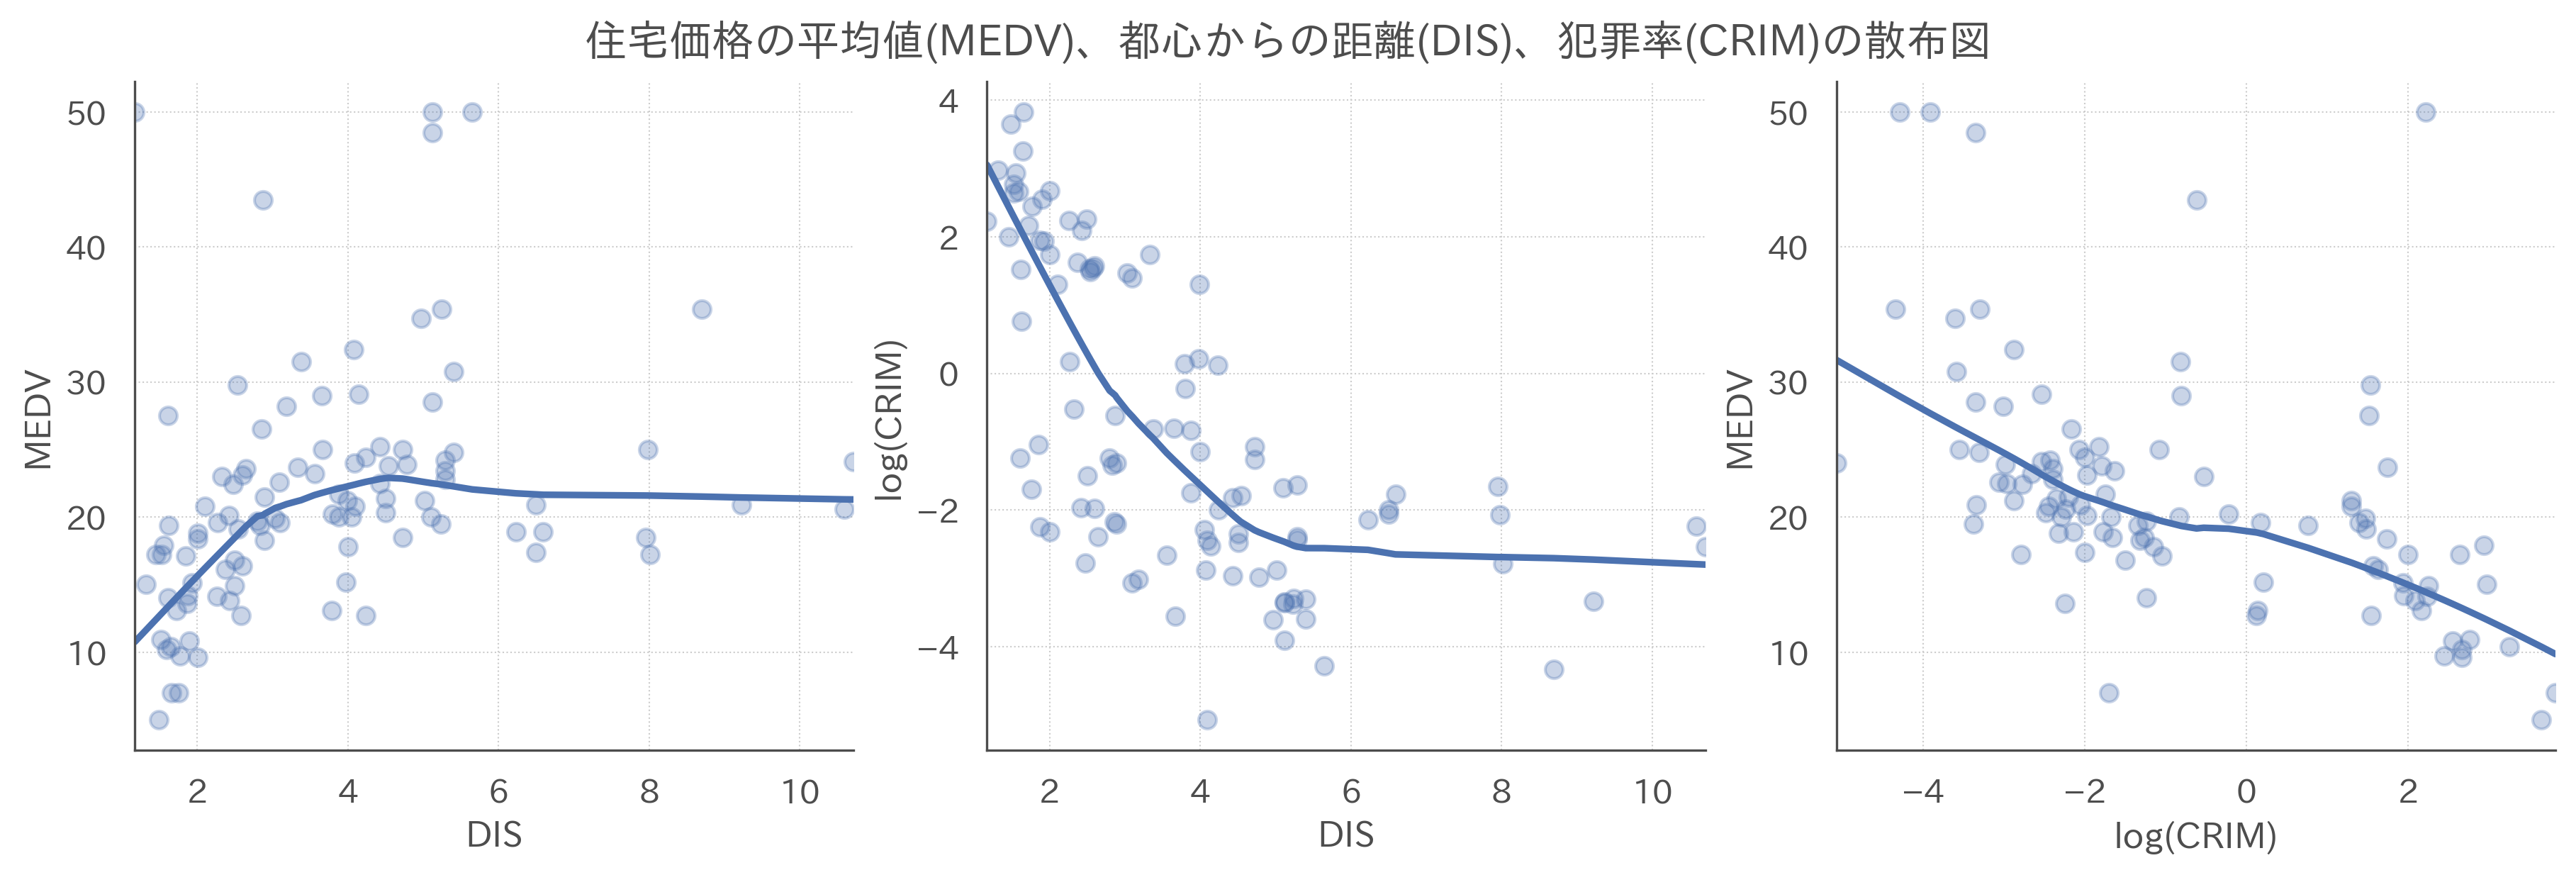

In [34]:
from functools import partial


def plot_lowess():
    """MEDV, DIS, CRIMの関係を散布図とLOWESSで可視化"""

    # LOWESSによる回帰曲線を追加した散布図
    lowess_plot = partial(
        sns.regplot,
        lowess=True,
        ci=None,
        scatter_kws={"alpha": 0.3}
    )

    # 3つの散布図を並べて可視化
    fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

    # 都心からの距離と住宅価格
    lowess_plot(x=X_test["DIS"], y=y_test, ax=axes[0])
    axes[0].set(xlabel="DIS", ylabel="MEDV")

    # 都心からの距離と犯罪率（対数）
    lowess_plot(x=X_test["DIS"], y=np.log(X_test["CRIM"]), ax=axes[1])
    axes[1].set(xlabel="DIS", ylabel="log(CRIM)")

    # 犯罪率（対数）と住宅価格
    lowess_plot(x=np.log(X_test["CRIM"]), y=y_test, ax=axes[2])
    axes[2].set(xlabel="log(CRIM)", ylabel="MEDV")

    fig.suptitle("住宅価格の平均値(MEDV)、都心からの距離(DIS)、犯罪率(CRIM)の散布図")
    
    fig.show()
    
    
plot_lowess()